##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb?force_kitty_mode=1&force_corgi_mode=1"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2023-09-01 04:18:09.659328: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-01 04:18:09.659378: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-01 04:18:09.659411: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

    8192/68606236 [..............................] - ETA: 0s

 4202496/68606236 [>.............................] - ETA: 1s

19546112/68606236 [=======>......................] - ETA: 0s

33587200/68606236 [=============>................] - ETA: 0s

41951232/68606236 [=================>............] - ETA: 0s

53149696/68606236 [======================>.......] - ETA: 0s

62996480/68606236 [==========================>...] - ETA: 0s

68606236/68606236 [==============================] - 0s 0us/step


Found 2000 files belonging to 2 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

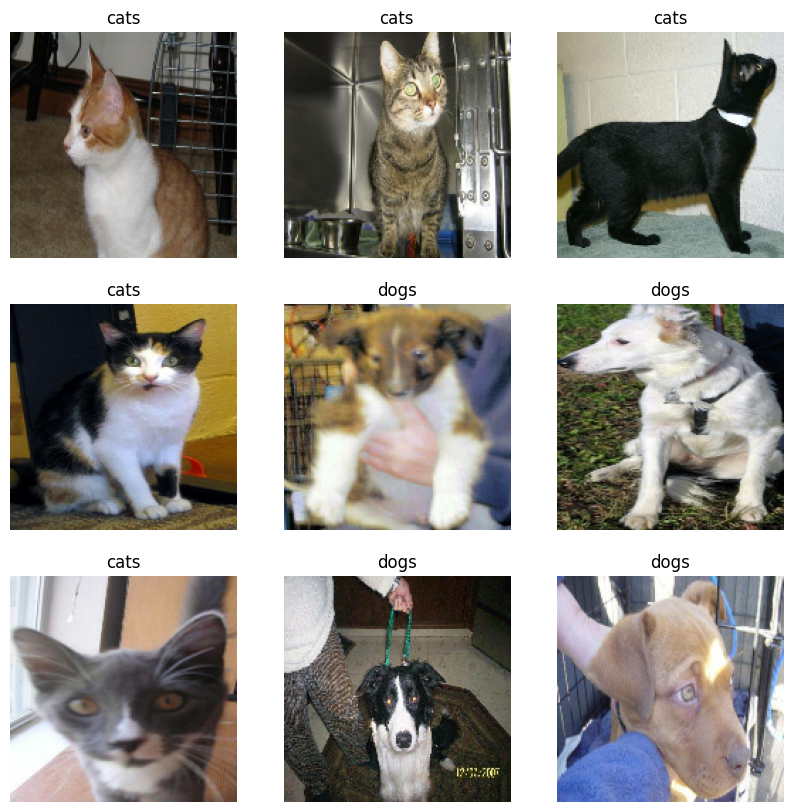

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate`, `Model.predict`, or `Model.call`.

Let's repeatedly apply these layers to the same image and see the result.

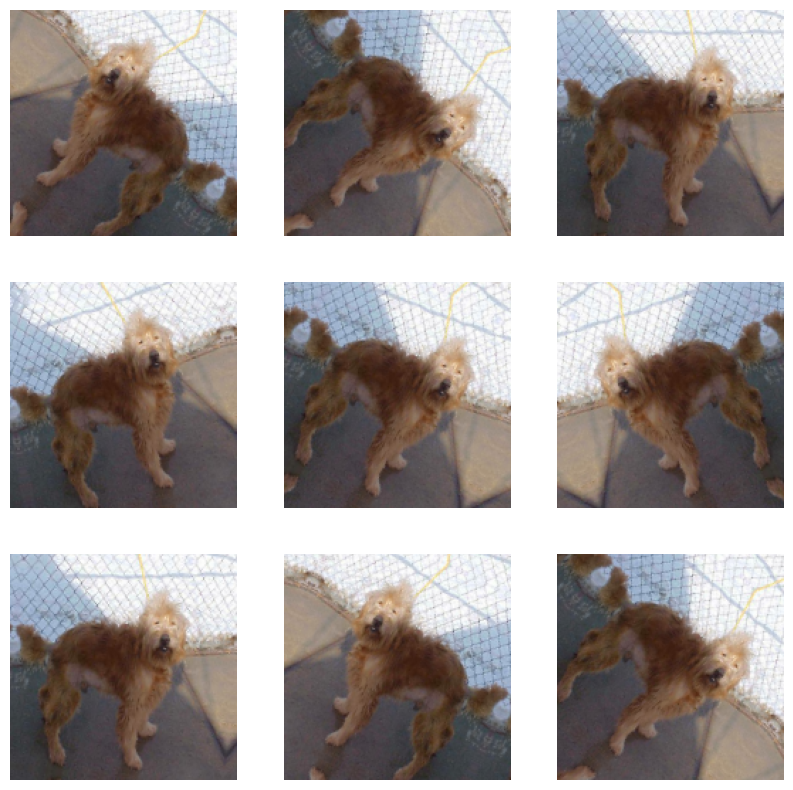

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [13]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [14]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

   8192/9406464 [..............................] - ETA: 0s

4202496/9406464 [============>.................] - ETA: 0s

8912896/9406464 [===========================>..] - ETA: 0s

9406464/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [16]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"


__________________________________________________________________________________________________


 Layer (type)                Output Shape                 Param #   Connected to                  


 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            


 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             


 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               


 on)                                                                                              


 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[0][0]']            


 expanded_conv_depthwise (D  (None, 80, 80, 32)           288       ['Conv1_relu[0][0]']          


 epthwiseConv2D)                                                                                  


 expanded_conv_depthwise_BN  (None, 80, 80, 32)           128       ['expanded_conv_depthwise[0][0


  (BatchNormalization)                                              ]']                           


 expanded_conv_depthwise_re  (None, 80, 80, 32)           0         ['expanded_conv_depthwise_BN[0


 lu (ReLU)                                                          ][0]']                        


 expanded_conv_project (Con  (None, 80, 80, 16)           512       ['expanded_conv_depthwise_relu


 v2D)                                                               [0][0]']                      


 expanded_conv_project_BN (  (None, 80, 80, 16)           64        ['expanded_conv_project[0][0]'


 BatchNormalization)                                                ]                             


 block_1_expand (Conv2D)     (None, 80, 80, 96)           1536      ['expanded_conv_project_BN[0][


                                                                    0]']                          


 block_1_expand_BN (BatchNo  (None, 80, 80, 96)           384       ['block_1_expand[0][0]']      


 rmalization)                                                                                     


 block_1_expand_relu (ReLU)  (None, 80, 80, 96)           0         ['block_1_expand_BN[0][0]']   


 block_1_pad (ZeroPadding2D  (None, 81, 81, 96)           0         ['block_1_expand_relu[0][0]'] 


 )                                                                                                


 block_1_depthwise (Depthwi  (None, 40, 40, 96)           864       ['block_1_pad[0][0]']         


 seConv2D)                                                                                        


 block_1_depthwise_BN (Batc  (None, 40, 40, 96)           384       ['block_1_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_1_depthwise_relu (Re  (None, 40, 40, 96)           0         ['block_1_depthwise_BN[0][0]']


 LU)                                                                                              


 block_1_project (Conv2D)    (None, 40, 40, 24)           2304      ['block_1_depthwise_relu[0][0]


                                                                    ']                            


 block_1_project_BN (BatchN  (None, 40, 40, 24)           96        ['block_1_project[0][0]']     


 ormalization)                                                                                    


 block_2_expand (Conv2D)     (None, 40, 40, 144)          3456      ['block_1_project_BN[0][0]']  


 block_2_expand_BN (BatchNo  (None, 40, 40, 144)          576       ['block_2_expand[0][0]']      


 rmalization)                                                                                     


 block_2_expand_relu (ReLU)  (None, 40, 40, 144)          0         ['block_2_expand_BN[0][0]']   


 block_2_depthwise (Depthwi  (None, 40, 40, 144)          1296      ['block_2_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_2_depthwise_BN (Batc  (None, 40, 40, 144)          576       ['block_2_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_2_depthwise_relu (Re  (None, 40, 40, 144)          0         ['block_2_depthwise_BN[0][0]']


 LU)                                                                                              


 block_2_project (Conv2D)    (None, 40, 40, 24)           3456      ['block_2_depthwise_relu[0][0]


                                                                    ']                            


 block_2_project_BN (BatchN  (None, 40, 40, 24)           96        ['block_2_project[0][0]']     


 ormalization)                                                                                    


 block_2_add (Add)           (None, 40, 40, 24)           0         ['block_1_project_BN[0][0]',  


                                                                     'block_2_project_BN[0][0]']  


 block_3_expand (Conv2D)     (None, 40, 40, 144)          3456      ['block_2_add[0][0]']         


 block_3_expand_BN (BatchNo  (None, 40, 40, 144)          576       ['block_3_expand[0][0]']      


 rmalization)                                                                                     


 block_3_expand_relu (ReLU)  (None, 40, 40, 144)          0         ['block_3_expand_BN[0][0]']   


 block_3_pad (ZeroPadding2D  (None, 41, 41, 144)          0         ['block_3_expand_relu[0][0]'] 


 )                                                                                                


 block_3_depthwise (Depthwi  (None, 20, 20, 144)          1296      ['block_3_pad[0][0]']         


 seConv2D)                                                                                        


 block_3_depthwise_BN (Batc  (None, 20, 20, 144)          576       ['block_3_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_3_depthwise_relu (Re  (None, 20, 20, 144)          0         ['block_3_depthwise_BN[0][0]']


 LU)                                                                                              


 block_3_project (Conv2D)    (None, 20, 20, 32)           4608      ['block_3_depthwise_relu[0][0]


                                                                    ']                            


 block_3_project_BN (BatchN  (None, 20, 20, 32)           128       ['block_3_project[0][0]']     


 ormalization)                                                                                    


 block_4_expand (Conv2D)     (None, 20, 20, 192)          6144      ['block_3_project_BN[0][0]']  


 block_4_expand_BN (BatchNo  (None, 20, 20, 192)          768       ['block_4_expand[0][0]']      


 rmalization)                                                                                     


 block_4_expand_relu (ReLU)  (None, 20, 20, 192)          0         ['block_4_expand_BN[0][0]']   


 block_4_depthwise (Depthwi  (None, 20, 20, 192)          1728      ['block_4_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_4_depthwise_BN (Batc  (None, 20, 20, 192)          768       ['block_4_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_4_depthwise_relu (Re  (None, 20, 20, 192)          0         ['block_4_depthwise_BN[0][0]']


 LU)                                                                                              


 block_4_project (Conv2D)    (None, 20, 20, 32)           6144      ['block_4_depthwise_relu[0][0]


                                                                    ']                            


 block_4_project_BN (BatchN  (None, 20, 20, 32)           128       ['block_4_project[0][0]']     


 ormalization)                                                                                    


 block_4_add (Add)           (None, 20, 20, 32)           0         ['block_3_project_BN[0][0]',  


                                                                     'block_4_project_BN[0][0]']  


 block_5_expand (Conv2D)     (None, 20, 20, 192)          6144      ['block_4_add[0][0]']         


 block_5_expand_BN (BatchNo  (None, 20, 20, 192)          768       ['block_5_expand[0][0]']      


 rmalization)                                                                                     


 block_5_expand_relu (ReLU)  (None, 20, 20, 192)          0         ['block_5_expand_BN[0][0]']   


 block_5_depthwise (Depthwi  (None, 20, 20, 192)          1728      ['block_5_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_5_depthwise_BN (Batc  (None, 20, 20, 192)          768       ['block_5_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_5_depthwise_relu (Re  (None, 20, 20, 192)          0         ['block_5_depthwise_BN[0][0]']


 LU)                                                                                              


 block_5_project (Conv2D)    (None, 20, 20, 32)           6144      ['block_5_depthwise_relu[0][0]


                                                                    ']                            


 block_5_project_BN (BatchN  (None, 20, 20, 32)           128       ['block_5_project[0][0]']     


 ormalization)                                                                                    


 block_5_add (Add)           (None, 20, 20, 32)           0         ['block_4_add[0][0]',         


                                                                     'block_5_project_BN[0][0]']  


 block_6_expand (Conv2D)     (None, 20, 20, 192)          6144      ['block_5_add[0][0]']         


 block_6_expand_BN (BatchNo  (None, 20, 20, 192)          768       ['block_6_expand[0][0]']      


 rmalization)                                                                                     


 block_6_expand_relu (ReLU)  (None, 20, 20, 192)          0         ['block_6_expand_BN[0][0]']   


 block_6_pad (ZeroPadding2D  (None, 21, 21, 192)          0         ['block_6_expand_relu[0][0]'] 


 )                                                                                                


 block_6_depthwise (Depthwi  (None, 10, 10, 192)          1728      ['block_6_pad[0][0]']         


 seConv2D)                                                                                        


 block_6_depthwise_BN (Batc  (None, 10, 10, 192)          768       ['block_6_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_6_depthwise_relu (Re  (None, 10, 10, 192)          0         ['block_6_depthwise_BN[0][0]']


 LU)                                                                                              


 block_6_project (Conv2D)    (None, 10, 10, 64)           12288     ['block_6_depthwise_relu[0][0]


                                                                    ']                            


 block_6_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_6_project[0][0]']     


 ormalization)                                                                                    


 block_7_expand (Conv2D)     (None, 10, 10, 384)          24576     ['block_6_project_BN[0][0]']  


 block_7_expand_BN (BatchNo  (None, 10, 10, 384)          1536      ['block_7_expand[0][0]']      


 rmalization)                                                                                     


 block_7_expand_relu (ReLU)  (None, 10, 10, 384)          0         ['block_7_expand_BN[0][0]']   


 block_7_depthwise (Depthwi  (None, 10, 10, 384)          3456      ['block_7_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_7_depthwise_BN (Batc  (None, 10, 10, 384)          1536      ['block_7_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_7_depthwise_relu (Re  (None, 10, 10, 384)          0         ['block_7_depthwise_BN[0][0]']


 LU)                                                                                              


 block_7_project (Conv2D)    (None, 10, 10, 64)           24576     ['block_7_depthwise_relu[0][0]


                                                                    ']                            


 block_7_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_7_project[0][0]']     


 ormalization)                                                                                    


 block_7_add (Add)           (None, 10, 10, 64)           0         ['block_6_project_BN[0][0]',  


                                                                     'block_7_project_BN[0][0]']  


 block_8_expand (Conv2D)     (None, 10, 10, 384)          24576     ['block_7_add[0][0]']         


 block_8_expand_BN (BatchNo  (None, 10, 10, 384)          1536      ['block_8_expand[0][0]']      


 rmalization)                                                                                     


 block_8_expand_relu (ReLU)  (None, 10, 10, 384)          0         ['block_8_expand_BN[0][0]']   


 block_8_depthwise (Depthwi  (None, 10, 10, 384)          3456      ['block_8_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_8_depthwise_BN (Batc  (None, 10, 10, 384)          1536      ['block_8_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_8_depthwise_relu (Re  (None, 10, 10, 384)          0         ['block_8_depthwise_BN[0][0]']


 LU)                                                                                              


 block_8_project (Conv2D)    (None, 10, 10, 64)           24576     ['block_8_depthwise_relu[0][0]


                                                                    ']                            


 block_8_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_8_project[0][0]']     


 ormalization)                                                                                    


 block_8_add (Add)           (None, 10, 10, 64)           0         ['block_7_add[0][0]',         


                                                                     'block_8_project_BN[0][0]']  


 block_9_expand (Conv2D)     (None, 10, 10, 384)          24576     ['block_8_add[0][0]']         


 block_9_expand_BN (BatchNo  (None, 10, 10, 384)          1536      ['block_9_expand[0][0]']      


 rmalization)                                                                                     


 block_9_expand_relu (ReLU)  (None, 10, 10, 384)          0         ['block_9_expand_BN[0][0]']   


 block_9_depthwise (Depthwi  (None, 10, 10, 384)          3456      ['block_9_expand_relu[0][0]'] 


 seConv2D)                                                                                        


 block_9_depthwise_BN (Batc  (None, 10, 10, 384)          1536      ['block_9_depthwise[0][0]']   


 hNormalization)                                                                                  


 block_9_depthwise_relu (Re  (None, 10, 10, 384)          0         ['block_9_depthwise_BN[0][0]']


 LU)                                                                                              


 block_9_project (Conv2D)    (None, 10, 10, 64)           24576     ['block_9_depthwise_relu[0][0]


                                                                    ']                            


 block_9_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_9_project[0][0]']     


 ormalization)                                                                                    


 block_9_add (Add)           (None, 10, 10, 64)           0         ['block_8_add[0][0]',         


                                                                     'block_9_project_BN[0][0]']  


 block_10_expand (Conv2D)    (None, 10, 10, 384)          24576     ['block_9_add[0][0]']         


 block_10_expand_BN (BatchN  (None, 10, 10, 384)          1536      ['block_10_expand[0][0]']     


 ormalization)                                                                                    


 block_10_expand_relu (ReLU  (None, 10, 10, 384)          0         ['block_10_expand_BN[0][0]']  


 )                                                                                                


 block_10_depthwise (Depthw  (None, 10, 10, 384)          3456      ['block_10_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_10_depthwise_BN (Bat  (None, 10, 10, 384)          1536      ['block_10_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_10_depthwise_relu (R  (None, 10, 10, 384)          0         ['block_10_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_10_project (Conv2D)   (None, 10, 10, 96)           36864     ['block_10_depthwise_relu[0][0


                                                                    ]']                           


 block_10_project_BN (Batch  (None, 10, 10, 96)           384       ['block_10_project[0][0]']    


 Normalization)                                                                                   


 block_11_expand (Conv2D)    (None, 10, 10, 576)          55296     ['block_10_project_BN[0][0]'] 


 block_11_expand_BN (BatchN  (None, 10, 10, 576)          2304      ['block_11_expand[0][0]']     


 ormalization)                                                                                    


 block_11_expand_relu (ReLU  (None, 10, 10, 576)          0         ['block_11_expand_BN[0][0]']  


 )                                                                                                


 block_11_depthwise (Depthw  (None, 10, 10, 576)          5184      ['block_11_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_11_depthwise_BN (Bat  (None, 10, 10, 576)          2304      ['block_11_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_11_depthwise_relu (R  (None, 10, 10, 576)          0         ['block_11_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_11_project (Conv2D)   (None, 10, 10, 96)           55296     ['block_11_depthwise_relu[0][0


                                                                    ]']                           


 block_11_project_BN (Batch  (None, 10, 10, 96)           384       ['block_11_project[0][0]']    


 Normalization)                                                                                   


 block_11_add (Add)          (None, 10, 10, 96)           0         ['block_10_project_BN[0][0]', 


                                                                     'block_11_project_BN[0][0]'] 


 block_12_expand (Conv2D)    (None, 10, 10, 576)          55296     ['block_11_add[0][0]']        


 block_12_expand_BN (BatchN  (None, 10, 10, 576)          2304      ['block_12_expand[0][0]']     


 ormalization)                                                                                    


 block_12_expand_relu (ReLU  (None, 10, 10, 576)          0         ['block_12_expand_BN[0][0]']  


 )                                                                                                


 block_12_depthwise (Depthw  (None, 10, 10, 576)          5184      ['block_12_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_12_depthwise_BN (Bat  (None, 10, 10, 576)          2304      ['block_12_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_12_depthwise_relu (R  (None, 10, 10, 576)          0         ['block_12_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_12_project (Conv2D)   (None, 10, 10, 96)           55296     ['block_12_depthwise_relu[0][0


                                                                    ]']                           


 block_12_project_BN (Batch  (None, 10, 10, 96)           384       ['block_12_project[0][0]']    


 Normalization)                                                                                   


 block_12_add (Add)          (None, 10, 10, 96)           0         ['block_11_add[0][0]',        


                                                                     'block_12_project_BN[0][0]'] 


 block_13_expand (Conv2D)    (None, 10, 10, 576)          55296     ['block_12_add[0][0]']        


 block_13_expand_BN (BatchN  (None, 10, 10, 576)          2304      ['block_13_expand[0][0]']     


 ormalization)                                                                                    


 block_13_expand_relu (ReLU  (None, 10, 10, 576)          0         ['block_13_expand_BN[0][0]']  


 )                                                                                                


 block_13_pad (ZeroPadding2  (None, 11, 11, 576)          0         ['block_13_expand_relu[0][0]']


 D)                                                                                               


 block_13_depthwise (Depthw  (None, 5, 5, 576)            5184      ['block_13_pad[0][0]']        


 iseConv2D)                                                                                       


 block_13_depthwise_BN (Bat  (None, 5, 5, 576)            2304      ['block_13_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_13_depthwise_relu (R  (None, 5, 5, 576)            0         ['block_13_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_13_project (Conv2D)   (None, 5, 5, 160)            92160     ['block_13_depthwise_relu[0][0


                                                                    ]']                           


 block_13_project_BN (Batch  (None, 5, 5, 160)            640       ['block_13_project[0][0]']    


 Normalization)                                                                                   


 block_14_expand (Conv2D)    (None, 5, 5, 960)            153600    ['block_13_project_BN[0][0]'] 


 block_14_expand_BN (BatchN  (None, 5, 5, 960)            3840      ['block_14_expand[0][0]']     


 ormalization)                                                                                    


 block_14_expand_relu (ReLU  (None, 5, 5, 960)            0         ['block_14_expand_BN[0][0]']  


 )                                                                                                


 block_14_depthwise (Depthw  (None, 5, 5, 960)            8640      ['block_14_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_14_depthwise_BN (Bat  (None, 5, 5, 960)            3840      ['block_14_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_14_depthwise_relu (R  (None, 5, 5, 960)            0         ['block_14_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_14_project (Conv2D)   (None, 5, 5, 160)            153600    ['block_14_depthwise_relu[0][0


                                                                    ]']                           


 block_14_project_BN (Batch  (None, 5, 5, 160)            640       ['block_14_project[0][0]']    


 Normalization)                                                                                   


 block_14_add (Add)          (None, 5, 5, 160)            0         ['block_13_project_BN[0][0]', 


                                                                     'block_14_project_BN[0][0]'] 


 block_15_expand (Conv2D)    (None, 5, 5, 960)            153600    ['block_14_add[0][0]']        


 block_15_expand_BN (BatchN  (None, 5, 5, 960)            3840      ['block_15_expand[0][0]']     


 ormalization)                                                                                    


 block_15_expand_relu (ReLU  (None, 5, 5, 960)            0         ['block_15_expand_BN[0][0]']  


 )                                                                                                


 block_15_depthwise (Depthw  (None, 5, 5, 960)            8640      ['block_15_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_15_depthwise_BN (Bat  (None, 5, 5, 960)            3840      ['block_15_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_15_depthwise_relu (R  (None, 5, 5, 960)            0         ['block_15_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_15_project (Conv2D)   (None, 5, 5, 160)            153600    ['block_15_depthwise_relu[0][0


                                                                    ]']                           


 block_15_project_BN (Batch  (None, 5, 5, 160)            640       ['block_15_project[0][0]']    


 Normalization)                                                                                   


 block_15_add (Add)          (None, 5, 5, 160)            0         ['block_14_add[0][0]',        


                                                                     'block_15_project_BN[0][0]'] 


 block_16_expand (Conv2D)    (None, 5, 5, 960)            153600    ['block_15_add[0][0]']        


 block_16_expand_BN (BatchN  (None, 5, 5, 960)            3840      ['block_16_expand[0][0]']     


 ormalization)                                                                                    


 block_16_expand_relu (ReLU  (None, 5, 5, 960)            0         ['block_16_expand_BN[0][0]']  


 )                                                                                                


 block_16_depthwise (Depthw  (None, 5, 5, 960)            8640      ['block_16_expand_relu[0][0]']


 iseConv2D)                                                                                       


 block_16_depthwise_BN (Bat  (None, 5, 5, 960)            3840      ['block_16_depthwise[0][0]']  


 chNormalization)                                                                                 


 block_16_depthwise_relu (R  (None, 5, 5, 960)            0         ['block_16_depthwise_BN[0][0]'


 eLU)                                                               ]                             


 block_16_project (Conv2D)   (None, 5, 5, 320)            307200    ['block_16_depthwise_relu[0][0


                                                                    ]']                           


 block_16_project_BN (Batch  (None, 5, 5, 320)            1280      ['block_16_project[0][0]']    


 Normalization)                                                                                   


 Conv_1 (Conv2D)             (None, 5, 5, 1280)           409600    ['block_16_project_BN[0][0]'] 


 Conv_1_bn (BatchNormalizat  (None, 5, 5, 1280)           5120      ['Conv_1[0][0]']              


 ion)                                                                                             


 out_relu (ReLU)             (None, 5, 5, 1280)           0         ['Conv_1_bn[0][0]']           


Total params: 2257984 (8.61 MB)


Trainable params: 0 (0.00 Byte)


Non-trainable params: 2257984 (8.61 MB)


__________________________________________________________________________________________________


### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [19]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
model.summary()

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         


 sequential (Sequential)     (None, 160, 160, 3)       0         


 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         


 a)                                                              


 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         


 da)                                                             


 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   


 tional)                                                         


 global_average_pooling2d (  (None, 1280)              0         


 GlobalAveragePooling2D)                                         


 dropout (Dropout)           (None, 1280)              0         


 dense (Dense)               (None, 1)                 1281      


Total params: 2259265 (8.62 MB)


Trainable params: 1281 (5.00 KB)


Non-trainable params: 2257984 (8.61 MB)


_________________________________________________________________


The 8+ million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [22]:
len(model.trainable_variables)

2

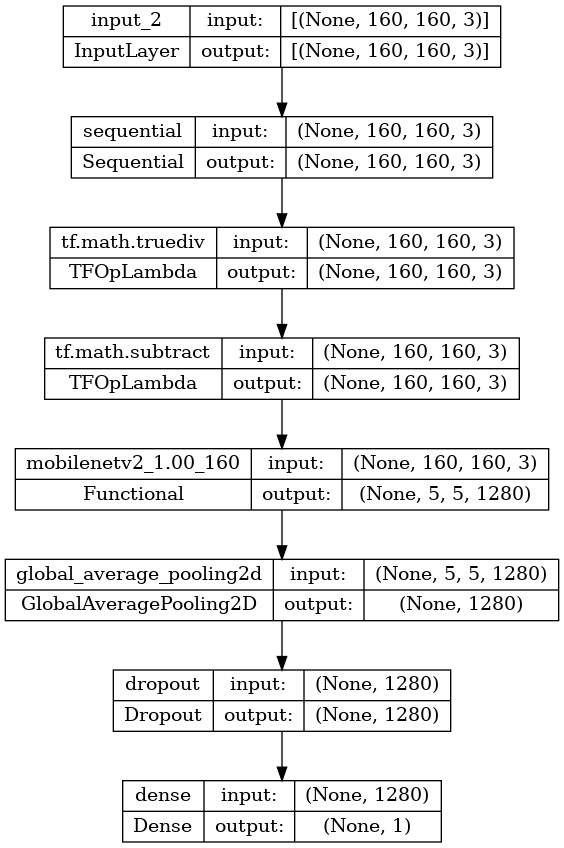

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

### Train the model

After training for 10 epochs, you should see ~96% accuracy on the validation set.


In [25]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

 1/26 [>.............................] - ETA: 42s - loss: 1.0648 - accuracy: 0.1250

 3/26 [==>...........................] - ETA: 0s - loss: 1.0844 - accuracy: 0.2083 

 5/26 [====>.........................] - ETA: 0s - loss: 1.0610 - accuracy: 0.2625

 7/26 [=======>......................] - ETA: 0s - loss: 1.0909 - accuracy: 0.2321

 9/26 [=========>....................] - ETA: 0s - loss: 1.1002 - accuracy: 0.2153

12/26 [============>.................] - ETA: 0s - loss: 1.1124 - accuracy: 0.2057

15/26 [================>.............] - ETA: 0s - loss: 1.0951 - accuracy: 0.2188

17/26 [==================>...........] - ETA: 0s - loss: 1.0864 - accuracy: 0.2206

20/26 [======================>.......] - ETA: 0s - loss: 1.0909 - accuracy: 0.2141

23/26 [=========================>....] - ETA: 0s - loss: 1.0858 - accuracy: 0.2228

26/26 [==============================] - ETA: 0s - loss: 1.0864 - accuracy: 0.2228

26/26 [==============================] - 3s 38ms/step - loss: 1.0864 - accuracy: 0.2228


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.09
initial accuracy: 0.22


In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


 1/63 [..............................] - ETA: 3:50 - loss: 1.0987 - accuracy: 0.3750

 3/63 [>.............................] - ETA: 2s - loss: 1.0552 - accuracy: 0.3750  

 5/63 [=>............................] - ETA: 2s - loss: 1.0972 - accuracy: 0.3250

 7/63 [==>...........................] - ETA: 1s - loss: 1.0572 - accuracy: 0.3482

 9/63 [===>..........................] - ETA: 1s - loss: 1.0780 - accuracy: 0.3333

11/63 [====>.........................] - ETA: 1s - loss: 1.0758 - accuracy: 0.3295

13/63 [=====>........................] - ETA: 1s - loss: 1.0636 - accuracy: 0.3317

15/63 [======>.......................] - ETA: 1s - loss: 1.0561 - accuracy: 0.3333

17/63 [=======>......................] - ETA: 1s - loss: 1.0455 - accuracy: 0.3364

19/63 [========>.....................] - ETA: 1s - loss: 1.0507 - accuracy: 0.3306

21/63 [=========>....................] - ETA: 1s - loss: 1.0428 - accuracy: 0.3304

23/63 [=========>....................] - ETA: 1s - loss: 1.0330 - accuracy: 0.3370

25/63 [==========>...................] - ETA: 1s - loss: 1.0200 - accuracy: 0.3462

27/63 [===========>..................] - ETA: 1s - loss: 1.0179 - accuracy: 0.3438

29/63 [============>.................] - ETA: 0s - loss: 1.0056 - accuracy: 0.3524

31/63 [=============>................] - ETA: 0s - loss: 0.9981 - accuracy: 0.3518

33/63 [==============>...............] - ETA: 0s - loss: 0.9940 - accuracy: 0.3523

35/63 [===============>..............] - ETA: 0s - loss: 0.9904 - accuracy: 0.3545

37/63 [================>.............] - ETA: 0s - loss: 0.9853 - accuracy: 0.3564

39/63 [=================>............] - ETA: 0s - loss: 0.9743 - accuracy: 0.3614

41/63 [==================>...........] - ETA: 0s - loss: 0.9704 - accuracy: 0.3643

43/63 [===================>..........] - ETA: 0s - loss: 0.9615 - accuracy: 0.3721

45/63 [====================>.........] - ETA: 0s - loss: 0.9558 - accuracy: 0.3722

47/63 [=====================>........] - ETA: 0s - loss: 0.9505 - accuracy: 0.3770

49/63 [======================>.......] - ETA: 0s - loss: 0.9446 - accuracy: 0.3827

51/63 [=======================>......] - ETA: 0s - loss: 0.9397 - accuracy: 0.3866

53/63 [========================>.....] - ETA: 0s - loss: 0.9395 - accuracy: 0.3868

55/63 [=========================>....] - ETA: 0s - loss: 0.9333 - accuracy: 0.3869

57/63 [==========================>...] - ETA: 0s - loss: 0.9269 - accuracy: 0.3931

59/63 [===========================>..] - ETA: 0s - loss: 0.9225 - accuracy: 0.3967

61/63 [============================>.] - ETA: 0s - loss: 0.9173 - accuracy: 0.3991

63/63 [==============================] - ETA: 0s - loss: 0.9132 - accuracy: 0.4025

63/63 [==============================] - 6s 45ms/step - loss: 0.9132 - accuracy: 0.4025 - val_loss: 0.7343 - val_accuracy: 0.5136


Epoch 2/10


 1/63 [..............................] - ETA: 3s - loss: 0.8686 - accuracy: 0.4375

 3/63 [>.............................] - ETA: 1s - loss: 0.8302 - accuracy: 0.5000

 5/63 [=>............................] - ETA: 1s - loss: 0.8058 - accuracy: 0.5188

 7/63 [==>...........................] - ETA: 1s - loss: 0.7704 - accuracy: 0.5357

 9/63 [===>..........................] - ETA: 1s - loss: 0.7690 - accuracy: 0.5347

11/63 [====>.........................] - ETA: 1s - loss: 0.7551 - accuracy: 0.5369

13/63 [=====>........................] - ETA: 1s - loss: 0.7487 - accuracy: 0.5433

15/63 [======>.......................] - ETA: 1s - loss: 0.7428 - accuracy: 0.5479

17/63 [=======>......................] - ETA: 1s - loss: 0.7375 - accuracy: 0.5588

19/63 [========>.....................] - ETA: 1s - loss: 0.7279 - accuracy: 0.5724

21/63 [=========>....................] - ETA: 1s - loss: 0.7249 - accuracy: 0.5714

23/63 [=========>....................] - ETA: 1s - loss: 0.7155 - accuracy: 0.5802

25/63 [==========>...................] - ETA: 1s - loss: 0.7079 - accuracy: 0.5900

27/63 [===========>..................] - ETA: 0s - loss: 0.7090 - accuracy: 0.5880

29/63 [============>.................] - ETA: 0s - loss: 0.7038 - accuracy: 0.5959

31/63 [=============>................] - ETA: 0s - loss: 0.7017 - accuracy: 0.5978

33/63 [==============>...............] - ETA: 0s - loss: 0.7001 - accuracy: 0.6023

35/63 [===============>..............] - ETA: 0s - loss: 0.6904 - accuracy: 0.6080

37/63 [================>.............] - ETA: 0s - loss: 0.6850 - accuracy: 0.6123

39/63 [=================>............] - ETA: 0s - loss: 0.6865 - accuracy: 0.6106

41/63 [==================>...........] - ETA: 0s - loss: 0.6816 - accuracy: 0.6113

43/63 [===================>..........] - ETA: 0s - loss: 0.6802 - accuracy: 0.6126

45/63 [====================>.........] - ETA: 0s - loss: 0.6769 - accuracy: 0.6146

47/63 [=====================>........] - ETA: 0s - loss: 0.6712 - accuracy: 0.6190

49/63 [======================>.......] - ETA: 0s - loss: 0.6677 - accuracy: 0.6218

51/63 [=======================>......] - ETA: 0s - loss: 0.6622 - accuracy: 0.6287

53/63 [========================>.....] - ETA: 0s - loss: 0.6589 - accuracy: 0.6297

55/63 [=========================>....] - ETA: 0s - loss: 0.6581 - accuracy: 0.6284

57/63 [==========================>...] - ETA: 0s - loss: 0.6578 - accuracy: 0.6288

59/63 [===========================>..] - ETA: 0s - loss: 0.6556 - accuracy: 0.6308

61/63 [============================>.] - ETA: 0s - loss: 0.6550 - accuracy: 0.6317

63/63 [==============================] - 2s 38ms/step - loss: 0.6518 - accuracy: 0.6340 - val_loss: 0.5089 - val_accuracy: 0.7847


Epoch 3/10


 1/63 [..............................] - ETA: 3s - loss: 0.5430 - accuracy: 0.6875

 3/63 [>.............................] - ETA: 1s - loss: 0.4990 - accuracy: 0.7604

 5/63 [=>............................] - ETA: 1s - loss: 0.5190 - accuracy: 0.7500

 7/63 [==>...........................] - ETA: 1s - loss: 0.5339 - accuracy: 0.7321

 9/63 [===>..........................] - ETA: 1s - loss: 0.5366 - accuracy: 0.7361

11/63 [====>.........................] - ETA: 1s - loss: 0.5414 - accuracy: 0.7330

13/63 [=====>........................] - ETA: 1s - loss: 0.5379 - accuracy: 0.7332

15/63 [======>.......................] - ETA: 1s - loss: 0.5407 - accuracy: 0.7271

17/63 [=======>......................] - ETA: 1s - loss: 0.5460 - accuracy: 0.7261

19/63 [========>.....................] - ETA: 1s - loss: 0.5436 - accuracy: 0.7220

21/63 [=========>....................] - ETA: 1s - loss: 0.5346 - accuracy: 0.7321

23/63 [=========>....................] - ETA: 1s - loss: 0.5276 - accuracy: 0.7337

25/63 [==========>...................] - ETA: 1s - loss: 0.5308 - accuracy: 0.7325

27/63 [===========>..................] - ETA: 0s - loss: 0.5292 - accuracy: 0.7338

29/63 [============>.................] - ETA: 0s - loss: 0.5236 - accuracy: 0.7392

31/63 [=============>................] - ETA: 0s - loss: 0.5200 - accuracy: 0.7419

33/63 [==============>...............] - ETA: 0s - loss: 0.5232 - accuracy: 0.7405

35/63 [===============>..............] - ETA: 0s - loss: 0.5180 - accuracy: 0.7473

37/63 [================>.............] - ETA: 0s - loss: 0.5125 - accuracy: 0.7517

39/63 [=================>............] - ETA: 0s - loss: 0.5103 - accuracy: 0.7524

41/63 [==================>...........] - ETA: 0s - loss: 0.5093 - accuracy: 0.7538

43/63 [===================>..........] - ETA: 0s - loss: 0.5049 - accuracy: 0.7580

45/63 [====================>.........] - ETA: 0s - loss: 0.5026 - accuracy: 0.7597

47/63 [=====================>........] - ETA: 0s - loss: 0.5028 - accuracy: 0.7600

49/63 [======================>.......] - ETA: 0s - loss: 0.5024 - accuracy: 0.7602

51/63 [=======================>......] - ETA: 0s - loss: 0.5013 - accuracy: 0.7616

53/63 [========================>.....] - ETA: 0s - loss: 0.5001 - accuracy: 0.7600

55/63 [=========================>....] - ETA: 0s - loss: 0.5009 - accuracy: 0.7608

57/63 [==========================>...] - ETA: 0s - loss: 0.4961 - accuracy: 0.7654

59/63 [===========================>..] - ETA: 0s - loss: 0.4967 - accuracy: 0.7643

61/63 [============================>.] - ETA: 0s - loss: 0.4948 - accuracy: 0.7664

63/63 [==============================] - 2s 37ms/step - loss: 0.4936 - accuracy: 0.7685 - val_loss: 0.3806 - val_accuracy: 0.8948


Epoch 4/10


 1/63 [..............................] - ETA: 3s - loss: 0.5335 - accuracy: 0.7812

 3/63 [>.............................] - ETA: 1s - loss: 0.4950 - accuracy: 0.7917

 5/63 [=>............................] - ETA: 1s - loss: 0.4706 - accuracy: 0.8000

 7/63 [==>...........................] - ETA: 1s - loss: 0.4423 - accuracy: 0.8214

 9/63 [===>..........................] - ETA: 1s - loss: 0.4397 - accuracy: 0.8090

11/63 [====>.........................] - ETA: 1s - loss: 0.4209 - accuracy: 0.8295

13/63 [=====>........................] - ETA: 1s - loss: 0.4141 - accuracy: 0.8389

15/63 [======>.......................] - ETA: 1s - loss: 0.4136 - accuracy: 0.8354

17/63 [=======>......................] - ETA: 1s - loss: 0.4211 - accuracy: 0.8217

19/63 [========>.....................] - ETA: 1s - loss: 0.4281 - accuracy: 0.8224

21/63 [=========>....................] - ETA: 1s - loss: 0.4304 - accuracy: 0.8214

23/63 [=========>....................] - ETA: 1s - loss: 0.4299 - accuracy: 0.8220

25/63 [==========>...................] - ETA: 1s - loss: 0.4250 - accuracy: 0.8238

27/63 [===========>..................] - ETA: 0s - loss: 0.4236 - accuracy: 0.8241

29/63 [============>.................] - ETA: 0s - loss: 0.4182 - accuracy: 0.8297

31/63 [=============>................] - ETA: 0s - loss: 0.4147 - accuracy: 0.8337

33/63 [==============>...............] - ETA: 0s - loss: 0.4097 - accuracy: 0.8362

35/63 [===============>..............] - ETA: 0s - loss: 0.4123 - accuracy: 0.8330

37/63 [================>.............] - ETA: 0s - loss: 0.4107 - accuracy: 0.8336

39/63 [=================>............] - ETA: 0s - loss: 0.4120 - accuracy: 0.8341

41/63 [==================>...........] - ETA: 0s - loss: 0.4101 - accuracy: 0.8369

43/63 [===================>..........] - ETA: 0s - loss: 0.4083 - accuracy: 0.8387

45/63 [====================>.........] - ETA: 0s - loss: 0.4095 - accuracy: 0.8368

47/63 [=====================>........] - ETA: 0s - loss: 0.4084 - accuracy: 0.8378

49/63 [======================>.......] - ETA: 0s - loss: 0.4091 - accuracy: 0.8367

51/63 [=======================>......] - ETA: 0s - loss: 0.4063 - accuracy: 0.8388

53/63 [========================>.....] - ETA: 0s - loss: 0.4058 - accuracy: 0.8379

55/63 [=========================>....] - ETA: 0s - loss: 0.4036 - accuracy: 0.8381

57/63 [==========================>...] - ETA: 0s - loss: 0.4013 - accuracy: 0.8399

59/63 [===========================>..] - ETA: 0s - loss: 0.3991 - accuracy: 0.8411

61/63 [============================>.] - ETA: 0s - loss: 0.3966 - accuracy: 0.8432

63/63 [==============================] - 2s 37ms/step - loss: 0.3950 - accuracy: 0.8440 - val_loss: 0.3052 - val_accuracy: 0.9307


Epoch 5/10


 1/63 [..............................] - ETA: 3s - loss: 0.3467 - accuracy: 0.8750

 3/63 [>.............................] - ETA: 1s - loss: 0.3811 - accuracy: 0.8333

 5/63 [=>............................] - ETA: 1s - loss: 0.3685 - accuracy: 0.8562

 7/63 [==>...........................] - ETA: 1s - loss: 0.3774 - accuracy: 0.8348

 9/63 [===>..........................] - ETA: 1s - loss: 0.3726 - accuracy: 0.8403

11/63 [====>.........................] - ETA: 1s - loss: 0.3782 - accuracy: 0.8438

13/63 [=====>........................] - ETA: 1s - loss: 0.3785 - accuracy: 0.8389

15/63 [======>.......................] - ETA: 1s - loss: 0.3793 - accuracy: 0.8500

17/63 [=======>......................] - ETA: 1s - loss: 0.3868 - accuracy: 0.8419

19/63 [========>.....................] - ETA: 1s - loss: 0.3836 - accuracy: 0.8454

21/63 [=========>....................] - ETA: 1s - loss: 0.3825 - accuracy: 0.8452

23/63 [=========>....................] - ETA: 1s - loss: 0.3804 - accuracy: 0.8478

25/63 [==========>...................] - ETA: 1s - loss: 0.3736 - accuracy: 0.8487

27/63 [===========>..................] - ETA: 0s - loss: 0.3700 - accuracy: 0.8507

29/63 [============>.................] - ETA: 0s - loss: 0.3691 - accuracy: 0.8502

31/63 [=============>................] - ETA: 0s - loss: 0.3692 - accuracy: 0.8528

33/63 [==============>...............] - ETA: 0s - loss: 0.3647 - accuracy: 0.8551

35/63 [===============>..............] - ETA: 0s - loss: 0.3614 - accuracy: 0.8589

37/63 [================>.............] - ETA: 0s - loss: 0.3636 - accuracy: 0.8556

39/63 [=================>............] - ETA: 0s - loss: 0.3641 - accuracy: 0.8558

41/63 [==================>...........] - ETA: 0s - loss: 0.3624 - accuracy: 0.8544

43/63 [===================>..........] - ETA: 0s - loss: 0.3578 - accuracy: 0.8576

45/63 [====================>.........] - ETA: 0s - loss: 0.3571 - accuracy: 0.8597

47/63 [=====================>........] - ETA: 0s - loss: 0.3549 - accuracy: 0.8617

49/63 [======================>.......] - ETA: 0s - loss: 0.3548 - accuracy: 0.8616

51/63 [=======================>......] - ETA: 0s - loss: 0.3559 - accuracy: 0.8615

53/63 [========================>.....] - ETA: 0s - loss: 0.3520 - accuracy: 0.8644

55/63 [=========================>....] - ETA: 0s - loss: 0.3499 - accuracy: 0.8659

57/63 [==========================>...] - ETA: 0s - loss: 0.3494 - accuracy: 0.8668

59/63 [===========================>..] - ETA: 0s - loss: 0.3521 - accuracy: 0.8639

61/63 [============================>.] - ETA: 0s - loss: 0.3525 - accuracy: 0.8642

63/63 [==============================] - 2s 37ms/step - loss: 0.3506 - accuracy: 0.8645 - val_loss: 0.2457 - val_accuracy: 0.9567


Epoch 6/10


 1/63 [..............................] - ETA: 3s - loss: 0.3352 - accuracy: 0.8750

 3/63 [>.............................] - ETA: 1s - loss: 0.3440 - accuracy: 0.8438

 5/63 [=>............................] - ETA: 1s - loss: 0.3294 - accuracy: 0.8813

 7/63 [==>...........................] - ETA: 1s - loss: 0.3514 - accuracy: 0.8750

 9/63 [===>..........................] - ETA: 1s - loss: 0.3440 - accuracy: 0.8681

11/63 [====>.........................] - ETA: 1s - loss: 0.3328 - accuracy: 0.8750

13/63 [=====>........................] - ETA: 1s - loss: 0.3206 - accuracy: 0.8918

15/63 [======>.......................] - ETA: 1s - loss: 0.3144 - accuracy: 0.8938

17/63 [=======>......................] - ETA: 1s - loss: 0.3183 - accuracy: 0.8860

19/63 [========>.....................] - ETA: 1s - loss: 0.3196 - accuracy: 0.8865

21/63 [=========>....................] - ETA: 1s - loss: 0.3204 - accuracy: 0.8854

23/63 [=========>....................] - ETA: 1s - loss: 0.3231 - accuracy: 0.8859

25/63 [==========>...................] - ETA: 1s - loss: 0.3224 - accuracy: 0.8850

27/63 [===========>..................] - ETA: 0s - loss: 0.3167 - accuracy: 0.8854

29/63 [============>.................] - ETA: 0s - loss: 0.3145 - accuracy: 0.8836

31/63 [=============>................] - ETA: 0s - loss: 0.3092 - accuracy: 0.8881

33/63 [==============>...............] - ETA: 0s - loss: 0.3114 - accuracy: 0.8883

35/63 [===============>..............] - ETA: 0s - loss: 0.3078 - accuracy: 0.8893

37/63 [================>.............] - ETA: 0s - loss: 0.3069 - accuracy: 0.8885

39/63 [=================>............] - ETA: 0s - loss: 0.3050 - accuracy: 0.8894

41/63 [==================>...........] - ETA: 0s - loss: 0.3022 - accuracy: 0.8895

43/63 [===================>..........] - ETA: 0s - loss: 0.3034 - accuracy: 0.8888

45/63 [====================>.........] - ETA: 0s - loss: 0.3058 - accuracy: 0.8861

47/63 [=====================>........] - ETA: 0s - loss: 0.3062 - accuracy: 0.8863

49/63 [======================>.......] - ETA: 0s - loss: 0.3070 - accuracy: 0.8852

51/63 [=======================>......] - ETA: 0s - loss: 0.3043 - accuracy: 0.8885

53/63 [========================>.....] - ETA: 0s - loss: 0.3065 - accuracy: 0.8862

55/63 [=========================>....] - ETA: 0s - loss: 0.3074 - accuracy: 0.8864

57/63 [==========================>...] - ETA: 0s - loss: 0.3057 - accuracy: 0.8882

59/63 [===========================>..] - ETA: 0s - loss: 0.3050 - accuracy: 0.8882

61/63 [============================>.] - ETA: 0s - loss: 0.3022 - accuracy: 0.8904

63/63 [==============================] - 2s 38ms/step - loss: 0.3016 - accuracy: 0.8915 - val_loss: 0.2156 - val_accuracy: 0.9592


Epoch 7/10


 1/63 [..............................] - ETA: 4s - loss: 0.3785 - accuracy: 0.7812

 3/63 [>.............................] - ETA: 1s - loss: 0.3166 - accuracy: 0.8542

 5/63 [=>............................] - ETA: 1s - loss: 0.3129 - accuracy: 0.8750

 7/63 [==>...........................] - ETA: 1s - loss: 0.3181 - accuracy: 0.8750

 9/63 [===>..........................] - ETA: 1s - loss: 0.2966 - accuracy: 0.8958

11/63 [====>.........................] - ETA: 1s - loss: 0.3029 - accuracy: 0.8892

13/63 [=====>........................] - ETA: 1s - loss: 0.2938 - accuracy: 0.8942

15/63 [======>.......................] - ETA: 1s - loss: 0.2936 - accuracy: 0.8938

17/63 [=======>......................] - ETA: 1s - loss: 0.2953 - accuracy: 0.8952

19/63 [========>.....................] - ETA: 1s - loss: 0.2903 - accuracy: 0.8947

21/63 [=========>....................] - ETA: 1s - loss: 0.2891 - accuracy: 0.8929

23/63 [=========>....................] - ETA: 1s - loss: 0.2921 - accuracy: 0.8954

25/63 [==========>...................] - ETA: 1s - loss: 0.2910 - accuracy: 0.8938

27/63 [===========>..................] - ETA: 0s - loss: 0.2907 - accuracy: 0.8924

29/63 [============>.................] - ETA: 0s - loss: 0.2885 - accuracy: 0.8955

31/63 [=============>................] - ETA: 0s - loss: 0.2841 - accuracy: 0.9002

33/63 [==============>...............] - ETA: 0s - loss: 0.2824 - accuracy: 0.8996

35/63 [===============>..............] - ETA: 0s - loss: 0.2794 - accuracy: 0.9009

37/63 [================>.............] - ETA: 0s - loss: 0.2772 - accuracy: 0.9020

39/63 [=================>............] - ETA: 0s - loss: 0.2766 - accuracy: 0.9022

41/63 [==================>...........] - ETA: 0s - loss: 0.2751 - accuracy: 0.9040

43/63 [===================>..........] - ETA: 0s - loss: 0.2736 - accuracy: 0.9033

45/63 [====================>.........] - ETA: 0s - loss: 0.2716 - accuracy: 0.9062

47/63 [=====================>........] - ETA: 0s - loss: 0.2708 - accuracy: 0.9069

49/63 [======================>.......] - ETA: 0s - loss: 0.2704 - accuracy: 0.9082

51/63 [=======================>......] - ETA: 0s - loss: 0.2711 - accuracy: 0.9075

53/63 [========================>.....] - ETA: 0s - loss: 0.2696 - accuracy: 0.9086

55/63 [=========================>....] - ETA: 0s - loss: 0.2698 - accuracy: 0.9080

57/63 [==========================>...] - ETA: 0s - loss: 0.2718 - accuracy: 0.9073

59/63 [===========================>..] - ETA: 0s - loss: 0.2712 - accuracy: 0.9062

61/63 [============================>.] - ETA: 0s - loss: 0.2700 - accuracy: 0.9073

63/63 [==============================] - 2s 37ms/step - loss: 0.2725 - accuracy: 0.9055 - val_loss: 0.1880 - val_accuracy: 0.9629


Epoch 8/10


 1/63 [..............................] - ETA: 3s - loss: 0.3521 - accuracy: 0.9062

 3/63 [>.............................] - ETA: 1s - loss: 0.2831 - accuracy: 0.9062

 5/63 [=>............................] - ETA: 1s - loss: 0.2703 - accuracy: 0.9187

 7/63 [==>...........................] - ETA: 1s - loss: 0.2762 - accuracy: 0.9107

 9/63 [===>..........................] - ETA: 1s - loss: 0.2779 - accuracy: 0.9062

11/63 [====>.........................] - ETA: 1s - loss: 0.2755 - accuracy: 0.9091

13/63 [=====>........................] - ETA: 1s - loss: 0.2681 - accuracy: 0.9111

15/63 [======>.......................] - ETA: 1s - loss: 0.2776 - accuracy: 0.9021

17/63 [=======>......................] - ETA: 1s - loss: 0.2744 - accuracy: 0.9062

19/63 [========>.....................] - ETA: 1s - loss: 0.2728 - accuracy: 0.9079

21/63 [=========>....................] - ETA: 1s - loss: 0.2706 - accuracy: 0.9077

23/63 [=========>....................] - ETA: 1s - loss: 0.2716 - accuracy: 0.9035

25/63 [==========>...................] - ETA: 1s - loss: 0.2720 - accuracy: 0.9025

27/63 [===========>..................] - ETA: 0s - loss: 0.2760 - accuracy: 0.8993

29/63 [============>.................] - ETA: 0s - loss: 0.2728 - accuracy: 0.9019

31/63 [=============>................] - ETA: 0s - loss: 0.2671 - accuracy: 0.9042

33/63 [==============>...............] - ETA: 0s - loss: 0.2655 - accuracy: 0.9053

35/63 [===============>..............] - ETA: 0s - loss: 0.2666 - accuracy: 0.9045

37/63 [================>.............] - ETA: 0s - loss: 0.2653 - accuracy: 0.9062

39/63 [=================>............] - ETA: 0s - loss: 0.2638 - accuracy: 0.9054

41/63 [==================>...........] - ETA: 0s - loss: 0.2629 - accuracy: 0.9062

43/63 [===================>..........] - ETA: 0s - loss: 0.2593 - accuracy: 0.9084

45/63 [====================>.........] - ETA: 0s - loss: 0.2617 - accuracy: 0.9062

47/63 [=====================>........] - ETA: 0s - loss: 0.2606 - accuracy: 0.9076

49/63 [======================>.......] - ETA: 0s - loss: 0.2639 - accuracy: 0.9056

51/63 [=======================>......] - ETA: 0s - loss: 0.2629 - accuracy: 0.9075

53/63 [========================>.....] - ETA: 0s - loss: 0.2627 - accuracy: 0.9080

55/63 [=========================>....] - ETA: 0s - loss: 0.2628 - accuracy: 0.9080

57/63 [==========================>...] - ETA: 0s - loss: 0.2607 - accuracy: 0.9090

59/63 [===========================>..] - ETA: 0s - loss: 0.2588 - accuracy: 0.9094

61/63 [============================>.] - ETA: 0s - loss: 0.2576 - accuracy: 0.9098

63/63 [==============================] - 2s 37ms/step - loss: 0.2567 - accuracy: 0.9100 - val_loss: 0.1705 - val_accuracy: 0.9592


Epoch 9/10


 1/63 [..............................] - ETA: 3s - loss: 0.2685 - accuracy: 0.8750

 3/63 [>.............................] - ETA: 1s - loss: 0.3213 - accuracy: 0.8542

 5/63 [=>............................] - ETA: 1s - loss: 0.2800 - accuracy: 0.8938

 7/63 [==>...........................] - ETA: 1s - loss: 0.2700 - accuracy: 0.8973

 9/63 [===>..........................] - ETA: 1s - loss: 0.2656 - accuracy: 0.9028

11/63 [====>.........................] - ETA: 1s - loss: 0.2638 - accuracy: 0.9006

13/63 [=====>........................] - ETA: 1s - loss: 0.2746 - accuracy: 0.8990

15/63 [======>.......................] - ETA: 1s - loss: 0.2636 - accuracy: 0.9083

17/63 [=======>......................] - ETA: 1s - loss: 0.2722 - accuracy: 0.8971

19/63 [========>.....................] - ETA: 1s - loss: 0.2623 - accuracy: 0.9030

21/63 [=========>....................] - ETA: 1s - loss: 0.2560 - accuracy: 0.9077

23/63 [=========>....................] - ETA: 1s - loss: 0.2528 - accuracy: 0.9090

25/63 [==========>...................] - ETA: 1s - loss: 0.2560 - accuracy: 0.9038

27/63 [===========>..................] - ETA: 0s - loss: 0.2628 - accuracy: 0.9005

29/63 [============>.................] - ETA: 0s - loss: 0.2590 - accuracy: 0.9019

31/63 [=============>................] - ETA: 0s - loss: 0.2607 - accuracy: 0.9012

33/63 [==============>...............] - ETA: 0s - loss: 0.2561 - accuracy: 0.9044

35/63 [===============>..............] - ETA: 0s - loss: 0.2531 - accuracy: 0.9054

37/63 [================>.............] - ETA: 0s - loss: 0.2572 - accuracy: 0.9029

39/63 [=================>............] - ETA: 0s - loss: 0.2558 - accuracy: 0.9054

41/63 [==================>...........] - ETA: 0s - loss: 0.2529 - accuracy: 0.9070

43/63 [===================>..........] - ETA: 0s - loss: 0.2507 - accuracy: 0.9092

45/63 [====================>.........] - ETA: 0s - loss: 0.2484 - accuracy: 0.9097

47/63 [=====================>........] - ETA: 0s - loss: 0.2448 - accuracy: 0.9116

49/63 [======================>.......] - ETA: 0s - loss: 0.2426 - accuracy: 0.9126

51/63 [=======================>......] - ETA: 0s - loss: 0.2425 - accuracy: 0.9118

53/63 [========================>.....] - ETA: 0s - loss: 0.2427 - accuracy: 0.9104

55/63 [=========================>....] - ETA: 0s - loss: 0.2416 - accuracy: 0.9108

57/63 [==========================>...] - ETA: 0s - loss: 0.2419 - accuracy: 0.9095

59/63 [===========================>..] - ETA: 0s - loss: 0.2402 - accuracy: 0.9110

61/63 [============================>.] - ETA: 0s - loss: 0.2407 - accuracy: 0.9109

63/63 [==============================] - 2s 37ms/step - loss: 0.2394 - accuracy: 0.9120 - val_loss: 0.1543 - val_accuracy: 0.9691


Epoch 10/10


 1/63 [..............................] - ETA: 3s - loss: 0.4163 - accuracy: 0.8438

 3/63 [>.............................] - ETA: 1s - loss: 0.3220 - accuracy: 0.8646

 5/63 [=>............................] - ETA: 1s - loss: 0.2914 - accuracy: 0.8813

 7/63 [==>...........................] - ETA: 1s - loss: 0.2701 - accuracy: 0.8973

 9/63 [===>..........................] - ETA: 1s - loss: 0.2506 - accuracy: 0.9132

11/63 [====>.........................] - ETA: 1s - loss: 0.2550 - accuracy: 0.9091

13/63 [=====>........................] - ETA: 1s - loss: 0.2458 - accuracy: 0.9159

15/63 [======>.......................] - ETA: 1s - loss: 0.2423 - accuracy: 0.9146

17/63 [=======>......................] - ETA: 1s - loss: 0.2354 - accuracy: 0.9173

19/63 [========>.....................] - ETA: 1s - loss: 0.2350 - accuracy: 0.9161

21/63 [=========>....................] - ETA: 1s - loss: 0.2401 - accuracy: 0.9122

23/63 [=========>....................] - ETA: 1s - loss: 0.2452 - accuracy: 0.9062

25/63 [==========>...................] - ETA: 1s - loss: 0.2469 - accuracy: 0.9062

27/63 [===========>..................] - ETA: 0s - loss: 0.2445 - accuracy: 0.9062

29/63 [============>.................] - ETA: 0s - loss: 0.2455 - accuracy: 0.9052

31/63 [=============>................] - ETA: 0s - loss: 0.2421 - accuracy: 0.9073

33/63 [==============>...............] - ETA: 0s - loss: 0.2387 - accuracy: 0.9091

35/63 [===============>..............] - ETA: 0s - loss: 0.2355 - accuracy: 0.9116

37/63 [================>.............] - ETA: 0s - loss: 0.2322 - accuracy: 0.9139

39/63 [=================>............] - ETA: 0s - loss: 0.2340 - accuracy: 0.9111

41/63 [==================>...........] - ETA: 0s - loss: 0.2350 - accuracy: 0.9101

43/63 [===================>..........] - ETA: 0s - loss: 0.2343 - accuracy: 0.9106

45/63 [====================>.........] - ETA: 0s - loss: 0.2324 - accuracy: 0.9125

47/63 [=====================>........] - ETA: 0s - loss: 0.2330 - accuracy: 0.9129

49/63 [======================>.......] - ETA: 0s - loss: 0.2321 - accuracy: 0.9120

51/63 [=======================>......] - ETA: 0s - loss: 0.2311 - accuracy: 0.9130

53/63 [========================>.....] - ETA: 0s - loss: 0.2296 - accuracy: 0.9133

55/63 [=========================>....] - ETA: 0s - loss: 0.2272 - accuracy: 0.9148

57/63 [==========================>...] - ETA: 0s - loss: 0.2270 - accuracy: 0.9145

59/63 [===========================>..] - ETA: 0s - loss: 0.2259 - accuracy: 0.9158

61/63 [============================>.] - ETA: 0s - loss: 0.2251 - accuracy: 0.9170

63/63 [==============================] - 2s 38ms/step - loss: 0.2243 - accuracy: 0.9170 - val_loss: 0.1387 - val_accuracy: 0.9678


### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

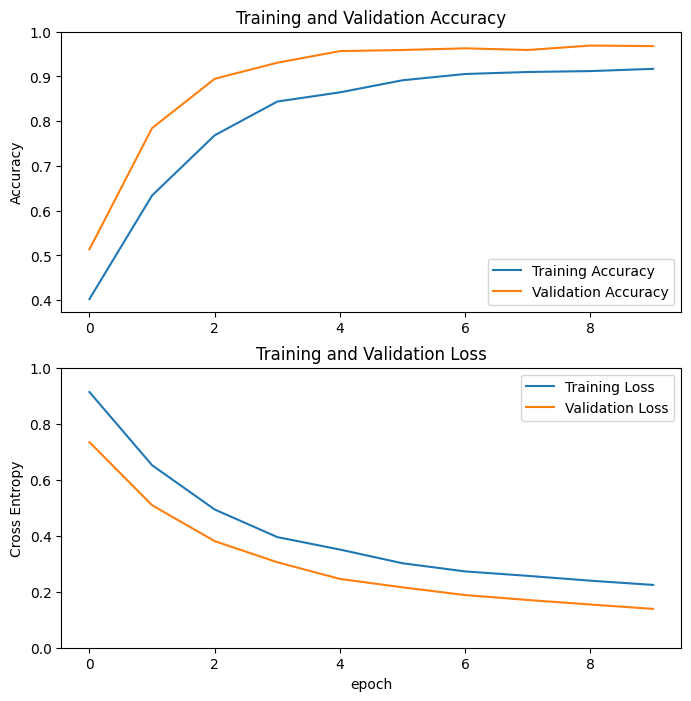

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [29]:
base_model.trainable = True

In [30]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [31]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [32]:
model.summary()

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         


 sequential (Sequential)     (None, 160, 160, 3)       0         


 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         


 a)                                                              


 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         


 da)                                                             


 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   


 tional)                                                         


 global_average_pooling2d (  (None, 1280)              0         


 GlobalAveragePooling2D)                                         


 dropout (Dropout)           (None, 1280)              0         


 dense (Dense)               (None, 1)                 1281      


Total params: 2259265 (8.62 MB)


Trainable params: 1862721 (7.11 MB)


Non-trainable params: 396544 (1.51 MB)


_________________________________________________________________


In [33]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [34]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


 1/63 [..............................] - ETA: 7:34 - loss: 0.1853 - accuracy: 0.9375

 2/63 [..............................] - ETA: 3s - loss: 0.1959 - accuracy: 0.9219  

 3/63 [>.............................] - ETA: 3s - loss: 0.2219 - accuracy: 0.8958

 4/63 [>.............................] - ETA: 3s - loss: 0.2184 - accuracy: 0.9062

 5/63 [=>............................] - ETA: 3s - loss: 0.2122 - accuracy: 0.9125

 7/63 [==>...........................] - ETA: 2s - loss: 0.2141 - accuracy: 0.9107

 9/63 [===>..........................] - ETA: 2s - loss: 0.2103 - accuracy: 0.9028

11/63 [====>.........................] - ETA: 2s - loss: 0.2051 - accuracy: 0.9006

13/63 [=====>........................] - ETA: 2s - loss: 0.1955 - accuracy: 0.9111

15/63 [======>.......................] - ETA: 1s - loss: 0.1889 - accuracy: 0.9167

17/63 [=======>......................] - ETA: 1s - loss: 0.1849 - accuracy: 0.9191

19/63 [========>.....................] - ETA: 1s - loss: 0.1828 - accuracy: 0.9194

21/63 [=========>....................] - ETA: 1s - loss: 0.1806 - accuracy: 0.9211

23/63 [=========>....................] - ETA: 1s - loss: 0.1823 - accuracy: 0.9198

25/63 [==========>...................] - ETA: 1s - loss: 0.1813 - accuracy: 0.9212

27/63 [===========>..................] - ETA: 1s - loss: 0.1868 - accuracy: 0.9178

29/63 [============>.................] - ETA: 1s - loss: 0.1819 - accuracy: 0.9213

31/63 [=============>................] - ETA: 1s - loss: 0.1777 - accuracy: 0.9244

33/63 [==============>...............] - ETA: 1s - loss: 0.1723 - accuracy: 0.9271

35/63 [===============>..............] - ETA: 1s - loss: 0.1722 - accuracy: 0.9268

37/63 [================>.............] - ETA: 0s - loss: 0.1701 - accuracy: 0.9282

39/63 [=================>............] - ETA: 0s - loss: 0.1730 - accuracy: 0.9263

41/63 [==================>...........] - ETA: 0s - loss: 0.1708 - accuracy: 0.9276

43/63 [===================>..........] - ETA: 0s - loss: 0.1692 - accuracy: 0.9288

45/63 [====================>.........] - ETA: 0s - loss: 0.1691 - accuracy: 0.9292

47/63 [=====================>........] - ETA: 0s - loss: 0.1696 - accuracy: 0.9295

49/63 [======================>.......] - ETA: 0s - loss: 0.1656 - accuracy: 0.9318

51/63 [=======================>......] - ETA: 0s - loss: 0.1629 - accuracy: 0.9332

53/63 [========================>.....] - ETA: 0s - loss: 0.1640 - accuracy: 0.9334

55/63 [=========================>....] - ETA: 0s - loss: 0.1619 - accuracy: 0.9335

57/63 [==========================>...] - ETA: 0s - loss: 0.1630 - accuracy: 0.9331

59/63 [===========================>..] - ETA: 0s - loss: 0.1603 - accuracy: 0.9349

61/63 [============================>.] - ETA: 0s - loss: 0.1584 - accuracy: 0.9349

63/63 [==============================] - ETA: 0s - loss: 0.1555 - accuracy: 0.9365

63/63 [==============================] - 11s 64ms/step - loss: 0.1555 - accuracy: 0.9365 - val_loss: 0.0543 - val_accuracy: 0.9827


Epoch 11/20


 1/63 [..............................] - ETA: 4s - loss: 0.0492 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 2s - loss: 0.1605 - accuracy: 0.9062

 5/63 [=>............................] - ETA: 2s - loss: 0.1236 - accuracy: 0.9312

 7/63 [==>...........................] - ETA: 2s - loss: 0.1303 - accuracy: 0.9375

 9/63 [===>..........................] - ETA: 1s - loss: 0.1333 - accuracy: 0.9340

11/63 [====>.........................] - ETA: 1s - loss: 0.1305 - accuracy: 0.9318

13/63 [=====>........................] - ETA: 1s - loss: 0.1294 - accuracy: 0.9303

15/63 [======>.......................] - ETA: 1s - loss: 0.1240 - accuracy: 0.9354

17/63 [=======>......................] - ETA: 1s - loss: 0.1318 - accuracy: 0.9301

19/63 [========>.....................] - ETA: 1s - loss: 0.1290 - accuracy: 0.9326

21/63 [=========>....................] - ETA: 1s - loss: 0.1243 - accuracy: 0.9360

23/63 [=========>....................] - ETA: 1s - loss: 0.1223 - accuracy: 0.9375

25/63 [==========>...................] - ETA: 1s - loss: 0.1319 - accuracy: 0.9325

27/63 [===========>..................] - ETA: 1s - loss: 0.1350 - accuracy: 0.9317

29/63 [============>.................] - ETA: 1s - loss: 0.1303 - accuracy: 0.9364

31/63 [=============>................] - ETA: 1s - loss: 0.1289 - accuracy: 0.9375

33/63 [==============>...............] - ETA: 1s - loss: 0.1243 - accuracy: 0.9403

35/63 [===============>..............] - ETA: 1s - loss: 0.1246 - accuracy: 0.9420

37/63 [================>.............] - ETA: 0s - loss: 0.1240 - accuracy: 0.9426

39/63 [=================>............] - ETA: 0s - loss: 0.1224 - accuracy: 0.9431

41/63 [==================>...........] - ETA: 0s - loss: 0.1179 - accuracy: 0.9459

43/63 [===================>..........] - ETA: 0s - loss: 0.1176 - accuracy: 0.9469

45/63 [====================>.........] - ETA: 0s - loss: 0.1203 - accuracy: 0.9458

47/63 [=====================>........] - ETA: 0s - loss: 0.1168 - accuracy: 0.9481

49/63 [======================>.......] - ETA: 0s - loss: 0.1183 - accuracy: 0.9471

51/63 [=======================>......] - ETA: 0s - loss: 0.1186 - accuracy: 0.9473

53/63 [========================>.....] - ETA: 0s - loss: 0.1160 - accuracy: 0.9493

55/63 [=========================>....] - ETA: 0s - loss: 0.1158 - accuracy: 0.9494

57/63 [==========================>...] - ETA: 0s - loss: 0.1175 - accuracy: 0.9479

59/63 [===========================>..] - ETA: 0s - loss: 0.1185 - accuracy: 0.9481

61/63 [============================>.] - ETA: 0s - loss: 0.1165 - accuracy: 0.9493

63/63 [==============================] - ETA: 0s - loss: 0.1151 - accuracy: 0.9500

63/63 [==============================] - 3s 47ms/step - loss: 0.1151 - accuracy: 0.9500 - val_loss: 0.0739 - val_accuracy: 0.9790


Epoch 12/20


 1/63 [..............................] - ETA: 4s - loss: 0.2969 - accuracy: 0.9062

 3/63 [>.............................] - ETA: 2s - loss: 0.1984 - accuracy: 0.9271

 5/63 [=>............................] - ETA: 2s - loss: 0.1698 - accuracy: 0.9312

 7/63 [==>...........................] - ETA: 2s - loss: 0.1432 - accuracy: 0.9420

 9/63 [===>..........................] - ETA: 1s - loss: 0.1315 - accuracy: 0.9479

11/63 [====>.........................] - ETA: 1s - loss: 0.1294 - accuracy: 0.9489

13/63 [=====>........................] - ETA: 1s - loss: 0.1210 - accuracy: 0.9519

15/63 [======>.......................] - ETA: 1s - loss: 0.1219 - accuracy: 0.9521

17/63 [=======>......................] - ETA: 1s - loss: 0.1118 - accuracy: 0.9559

19/63 [========>.....................] - ETA: 1s - loss: 0.1121 - accuracy: 0.9556

21/63 [=========>....................] - ETA: 1s - loss: 0.1140 - accuracy: 0.9554

23/63 [=========>....................] - ETA: 1s - loss: 0.1178 - accuracy: 0.9538

25/63 [==========>...................] - ETA: 1s - loss: 0.1202 - accuracy: 0.9525

27/63 [===========>..................] - ETA: 1s - loss: 0.1164 - accuracy: 0.9537

29/63 [============>.................] - ETA: 1s - loss: 0.1131 - accuracy: 0.9547

31/63 [=============>................] - ETA: 1s - loss: 0.1114 - accuracy: 0.9556

33/63 [==============>...............] - ETA: 1s - loss: 0.1085 - accuracy: 0.9574

35/63 [===============>..............] - ETA: 1s - loss: 0.1065 - accuracy: 0.9589

37/63 [================>.............] - ETA: 0s - loss: 0.1047 - accuracy: 0.9603

39/63 [=================>............] - ETA: 0s - loss: 0.1087 - accuracy: 0.9591

41/63 [==================>...........] - ETA: 0s - loss: 0.1072 - accuracy: 0.9588

43/63 [===================>..........] - ETA: 0s - loss: 0.1104 - accuracy: 0.9586

45/63 [====================>.........] - ETA: 0s - loss: 0.1075 - accuracy: 0.9604

47/63 [=====================>........] - ETA: 0s - loss: 0.1068 - accuracy: 0.9614

49/63 [======================>.......] - ETA: 0s - loss: 0.1051 - accuracy: 0.9617

51/63 [=======================>......] - ETA: 0s - loss: 0.1027 - accuracy: 0.9632

53/63 [========================>.....] - ETA: 0s - loss: 0.1019 - accuracy: 0.9640

55/63 [=========================>....] - ETA: 0s - loss: 0.1035 - accuracy: 0.9631

57/63 [==========================>...] - ETA: 0s - loss: 0.1065 - accuracy: 0.9616

59/63 [===========================>..] - ETA: 0s - loss: 0.1059 - accuracy: 0.9613

61/63 [============================>.] - ETA: 0s - loss: 0.1064 - accuracy: 0.9621

63/63 [==============================] - ETA: 0s - loss: 0.1042 - accuracy: 0.9630

63/63 [==============================] - 3s 47ms/step - loss: 0.1042 - accuracy: 0.9630 - val_loss: 0.0415 - val_accuracy: 0.9851


Epoch 13/20


 1/63 [..............................] - ETA: 4s - loss: 0.0754 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 2s - loss: 0.1138 - accuracy: 0.9583

 5/63 [=>............................] - ETA: 2s - loss: 0.1411 - accuracy: 0.9438

 7/63 [==>...........................] - ETA: 2s - loss: 0.1350 - accuracy: 0.9464

 9/63 [===>..........................] - ETA: 1s - loss: 0.1312 - accuracy: 0.9514

11/63 [====>.........................] - ETA: 1s - loss: 0.1265 - accuracy: 0.9545

13/63 [=====>........................] - ETA: 1s - loss: 0.1241 - accuracy: 0.9543

15/63 [======>.......................] - ETA: 1s - loss: 0.1213 - accuracy: 0.9542

17/63 [=======>......................] - ETA: 1s - loss: 0.1142 - accuracy: 0.9577

19/63 [========>.....................] - ETA: 1s - loss: 0.1131 - accuracy: 0.9572

21/63 [=========>....................] - ETA: 1s - loss: 0.1090 - accuracy: 0.9583

23/63 [=========>....................] - ETA: 1s - loss: 0.1101 - accuracy: 0.9579

25/63 [==========>...................] - ETA: 1s - loss: 0.1095 - accuracy: 0.9600

27/63 [===========>..................] - ETA: 1s - loss: 0.1104 - accuracy: 0.9606

29/63 [============>.................] - ETA: 1s - loss: 0.1054 - accuracy: 0.9634

31/63 [=============>................] - ETA: 1s - loss: 0.1076 - accuracy: 0.9597

33/63 [==============>...............] - ETA: 1s - loss: 0.1081 - accuracy: 0.9602

35/63 [===============>..............] - ETA: 1s - loss: 0.1042 - accuracy: 0.9616

37/63 [================>.............] - ETA: 0s - loss: 0.1055 - accuracy: 0.9611

39/63 [=================>............] - ETA: 0s - loss: 0.1049 - accuracy: 0.9607

41/63 [==================>...........] - ETA: 0s - loss: 0.1044 - accuracy: 0.9604

43/63 [===================>..........] - ETA: 0s - loss: 0.1041 - accuracy: 0.9600

45/63 [====================>.........] - ETA: 0s - loss: 0.1020 - accuracy: 0.9604

47/63 [=====================>........] - ETA: 0s - loss: 0.1021 - accuracy: 0.9601

49/63 [======================>.......] - ETA: 0s - loss: 0.1008 - accuracy: 0.9605

51/63 [=======================>......] - ETA: 0s - loss: 0.1036 - accuracy: 0.9608

53/63 [========================>.....] - ETA: 0s - loss: 0.1019 - accuracy: 0.9605

55/63 [=========================>....] - ETA: 0s - loss: 0.0996 - accuracy: 0.9619

57/63 [==========================>...] - ETA: 0s - loss: 0.1027 - accuracy: 0.9611

59/63 [===========================>..] - ETA: 0s - loss: 0.1038 - accuracy: 0.9608

61/63 [============================>.] - ETA: 0s - loss: 0.1061 - accuracy: 0.9600

63/63 [==============================] - ETA: 0s - loss: 0.1043 - accuracy: 0.9610

63/63 [==============================] - 3s 47ms/step - loss: 0.1043 - accuracy: 0.9610 - val_loss: 0.0362 - val_accuracy: 0.9889


Epoch 14/20


 1/63 [..............................] - ETA: 4s - loss: 0.0757 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 2s - loss: 0.0857 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 2s - loss: 0.0865 - accuracy: 0.9563

 7/63 [==>...........................] - ETA: 2s - loss: 0.0758 - accuracy: 0.9598

 9/63 [===>..........................] - ETA: 1s - loss: 0.0856 - accuracy: 0.9549

11/63 [====>.........................] - ETA: 1s - loss: 0.0721 - accuracy: 0.9631

13/63 [=====>........................] - ETA: 1s - loss: 0.1024 - accuracy: 0.9543

15/63 [======>.......................] - ETA: 1s - loss: 0.0980 - accuracy: 0.9563

17/63 [=======>......................] - ETA: 1s - loss: 0.0951 - accuracy: 0.9577

19/63 [========>.....................] - ETA: 1s - loss: 0.0982 - accuracy: 0.9589

21/63 [=========>....................] - ETA: 1s - loss: 0.0944 - accuracy: 0.9598

23/63 [=========>....................] - ETA: 1s - loss: 0.0941 - accuracy: 0.9592

25/63 [==========>...................] - ETA: 1s - loss: 0.0990 - accuracy: 0.9563

27/63 [===========>..................] - ETA: 1s - loss: 0.0986 - accuracy: 0.9560

29/63 [============>.................] - ETA: 1s - loss: 0.0964 - accuracy: 0.9569

31/63 [=============>................] - ETA: 1s - loss: 0.0941 - accuracy: 0.9577

33/63 [==============>...............] - ETA: 1s - loss: 0.0918 - accuracy: 0.9593

35/63 [===============>..............] - ETA: 1s - loss: 0.0894 - accuracy: 0.9607

37/63 [================>.............] - ETA: 0s - loss: 0.0886 - accuracy: 0.9611

39/63 [=================>............] - ETA: 0s - loss: 0.0861 - accuracy: 0.9631

41/63 [==================>...........] - ETA: 0s - loss: 0.0856 - accuracy: 0.9634

43/63 [===================>..........] - ETA: 0s - loss: 0.0888 - accuracy: 0.9629

45/63 [====================>.........] - ETA: 0s - loss: 0.0876 - accuracy: 0.9632

47/63 [=====================>........] - ETA: 0s - loss: 0.0876 - accuracy: 0.9621

49/63 [======================>.......] - ETA: 0s - loss: 0.0855 - accuracy: 0.9630

51/63 [=======================>......] - ETA: 0s - loss: 0.0841 - accuracy: 0.9632

53/63 [========================>.....] - ETA: 0s - loss: 0.0838 - accuracy: 0.9640

55/63 [=========================>....] - ETA: 0s - loss: 0.0817 - accuracy: 0.9653

57/63 [==========================>...] - ETA: 0s - loss: 0.0815 - accuracy: 0.9655

59/63 [===========================>..] - ETA: 0s - loss: 0.0813 - accuracy: 0.9650

61/63 [============================>.] - ETA: 0s - loss: 0.0814 - accuracy: 0.9652

63/63 [==============================] - ETA: 0s - loss: 0.0814 - accuracy: 0.9650

63/63 [==============================] - 3s 47ms/step - loss: 0.0814 - accuracy: 0.9650 - val_loss: 0.0371 - val_accuracy: 0.9864


Epoch 15/20


 1/63 [..............................] - ETA: 4s - loss: 0.1518 - accuracy: 0.9062

 3/63 [>.............................] - ETA: 2s - loss: 0.1682 - accuracy: 0.9375

 5/63 [=>............................] - ETA: 2s - loss: 0.1208 - accuracy: 0.9563

 7/63 [==>...........................] - ETA: 2s - loss: 0.0951 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 2s - loss: 0.1162 - accuracy: 0.9549

11/63 [====>.........................] - ETA: 1s - loss: 0.1064 - accuracy: 0.9574

13/63 [=====>........................] - ETA: 1s - loss: 0.1014 - accuracy: 0.9567

15/63 [======>.......................] - ETA: 1s - loss: 0.0951 - accuracy: 0.9604

17/63 [=======>......................] - ETA: 1s - loss: 0.0957 - accuracy: 0.9577

19/63 [========>.....................] - ETA: 1s - loss: 0.0971 - accuracy: 0.9556

21/63 [=========>....................] - ETA: 1s - loss: 0.0966 - accuracy: 0.9568

23/63 [=========>....................] - ETA: 1s - loss: 0.0950 - accuracy: 0.9579

25/63 [==========>...................] - ETA: 1s - loss: 0.0951 - accuracy: 0.9563

27/63 [===========>..................] - ETA: 1s - loss: 0.0906 - accuracy: 0.9595

29/63 [============>.................] - ETA: 1s - loss: 0.0877 - accuracy: 0.9601

31/63 [=============>................] - ETA: 1s - loss: 0.0891 - accuracy: 0.9607

33/63 [==============>...............] - ETA: 1s - loss: 0.0847 - accuracy: 0.9631

35/63 [===============>..............] - ETA: 1s - loss: 0.0814 - accuracy: 0.9652

37/63 [================>.............] - ETA: 0s - loss: 0.0782 - accuracy: 0.9671

39/63 [=================>............] - ETA: 0s - loss: 0.0766 - accuracy: 0.9679

41/63 [==================>...........] - ETA: 0s - loss: 0.0755 - accuracy: 0.9680

43/63 [===================>..........] - ETA: 0s - loss: 0.0797 - accuracy: 0.9666

45/63 [====================>.........] - ETA: 0s - loss: 0.0794 - accuracy: 0.9674

47/63 [=====================>........] - ETA: 0s - loss: 0.0784 - accuracy: 0.9681

49/63 [======================>.......] - ETA: 0s - loss: 0.0773 - accuracy: 0.9688

51/63 [=======================>......] - ETA: 0s - loss: 0.0770 - accuracy: 0.9681

53/63 [========================>.....] - ETA: 0s - loss: 0.0762 - accuracy: 0.9682

55/63 [=========================>....] - ETA: 0s - loss: 0.0774 - accuracy: 0.9682

57/63 [==========================>...] - ETA: 0s - loss: 0.0773 - accuracy: 0.9677

59/63 [===========================>..] - ETA: 0s - loss: 0.0780 - accuracy: 0.9672

61/63 [============================>.] - ETA: 0s - loss: 0.0771 - accuracy: 0.9672

63/63 [==============================] - ETA: 0s - loss: 0.0770 - accuracy: 0.9670

63/63 [==============================] - 3s 48ms/step - loss: 0.0770 - accuracy: 0.9670 - val_loss: 0.0417 - val_accuracy: 0.9839


Epoch 16/20


 1/63 [..............................] - ETA: 4s - loss: 0.0490 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0436 - accuracy: 0.9792

 5/63 [=>............................] - ETA: 2s - loss: 0.0442 - accuracy: 0.9812

 7/63 [==>...........................] - ETA: 2s - loss: 0.0422 - accuracy: 0.9821

 9/63 [===>..........................] - ETA: 1s - loss: 0.0722 - accuracy: 0.9722

11/63 [====>.........................] - ETA: 1s - loss: 0.0806 - accuracy: 0.9688

13/63 [=====>........................] - ETA: 1s - loss: 0.0767 - accuracy: 0.9712

15/63 [======>.......................] - ETA: 1s - loss: 0.0748 - accuracy: 0.9708

17/63 [=======>......................] - ETA: 1s - loss: 0.0720 - accuracy: 0.9724

19/63 [========>.....................] - ETA: 1s - loss: 0.0670 - accuracy: 0.9753

21/63 [=========>....................] - ETA: 1s - loss: 0.0673 - accuracy: 0.9732

23/63 [=========>....................] - ETA: 1s - loss: 0.0651 - accuracy: 0.9742

25/63 [==========>...................] - ETA: 1s - loss: 0.0669 - accuracy: 0.9737

27/63 [===========>..................] - ETA: 1s - loss: 0.0715 - accuracy: 0.9734

29/63 [============>.................] - ETA: 1s - loss: 0.0721 - accuracy: 0.9731

31/63 [=============>................] - ETA: 1s - loss: 0.0706 - accuracy: 0.9728

33/63 [==============>...............] - ETA: 1s - loss: 0.0676 - accuracy: 0.9744

35/63 [===============>..............] - ETA: 1s - loss: 0.0650 - accuracy: 0.9759

37/63 [================>.............] - ETA: 0s - loss: 0.0631 - accuracy: 0.9764

39/63 [=================>............] - ETA: 0s - loss: 0.0615 - accuracy: 0.9768

41/63 [==================>...........] - ETA: 0s - loss: 0.0606 - accuracy: 0.9779

43/63 [===================>..........] - ETA: 0s - loss: 0.0613 - accuracy: 0.9775

45/63 [====================>.........] - ETA: 0s - loss: 0.0605 - accuracy: 0.9785

47/63 [=====================>........] - ETA: 0s - loss: 0.0630 - accuracy: 0.9781

49/63 [======================>.......] - ETA: 0s - loss: 0.0689 - accuracy: 0.9764

51/63 [=======================>......] - ETA: 0s - loss: 0.0719 - accuracy: 0.9749

53/63 [========================>.....] - ETA: 0s - loss: 0.0725 - accuracy: 0.9746

55/63 [=========================>....] - ETA: 0s - loss: 0.0733 - accuracy: 0.9750

57/63 [==========================>...] - ETA: 0s - loss: 0.0726 - accuracy: 0.9742

59/63 [===========================>..] - ETA: 0s - loss: 0.0722 - accuracy: 0.9740

61/63 [============================>.] - ETA: 0s - loss: 0.0711 - accuracy: 0.9744

63/63 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9735

63/63 [==============================] - 3s 48ms/step - loss: 0.0719 - accuracy: 0.9735 - val_loss: 0.0363 - val_accuracy: 0.9839


Epoch 17/20


 1/63 [..............................] - ETA: 4s - loss: 0.0579 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 2s - loss: 0.0418 - accuracy: 0.9896

 5/63 [=>............................] - ETA: 2s - loss: 0.0381 - accuracy: 0.9937

 7/63 [==>...........................] - ETA: 2s - loss: 0.0743 - accuracy: 0.9777

 9/63 [===>..........................] - ETA: 2s - loss: 0.0760 - accuracy: 0.9653

11/63 [====>.........................] - ETA: 1s - loss: 0.0707 - accuracy: 0.9688

13/63 [=====>........................] - ETA: 1s - loss: 0.0713 - accuracy: 0.9688

15/63 [======>.......................] - ETA: 1s - loss: 0.0760 - accuracy: 0.9667

17/63 [=======>......................] - ETA: 1s - loss: 0.0770 - accuracy: 0.9669

19/63 [========>.....................] - ETA: 1s - loss: 0.0900 - accuracy: 0.9589

21/63 [=========>....................] - ETA: 1s - loss: 0.0892 - accuracy: 0.9598

23/63 [=========>....................] - ETA: 1s - loss: 0.0833 - accuracy: 0.9633

25/63 [==========>...................] - ETA: 1s - loss: 0.0790 - accuracy: 0.9650

27/63 [===========>..................] - ETA: 1s - loss: 0.0784 - accuracy: 0.9641

29/63 [============>.................] - ETA: 1s - loss: 0.0791 - accuracy: 0.9644

31/63 [=============>................] - ETA: 1s - loss: 0.0801 - accuracy: 0.9647

33/63 [==============>...............] - ETA: 1s - loss: 0.0830 - accuracy: 0.9631

35/63 [===============>..............] - ETA: 1s - loss: 0.0864 - accuracy: 0.9607

37/63 [================>.............] - ETA: 0s - loss: 0.0857 - accuracy: 0.9611

39/63 [=================>............] - ETA: 0s - loss: 0.0832 - accuracy: 0.9631

41/63 [==================>...........] - ETA: 0s - loss: 0.0801 - accuracy: 0.9649

43/63 [===================>..........] - ETA: 0s - loss: 0.0813 - accuracy: 0.9644

45/63 [====================>.........] - ETA: 0s - loss: 0.0807 - accuracy: 0.9653

47/63 [=====================>........] - ETA: 0s - loss: 0.0813 - accuracy: 0.9654

49/63 [======================>.......] - ETA: 0s - loss: 0.0801 - accuracy: 0.9662

51/63 [=======================>......] - ETA: 0s - loss: 0.0777 - accuracy: 0.9675

53/63 [========================>.....] - ETA: 0s - loss: 0.0779 - accuracy: 0.9682

55/63 [=========================>....] - ETA: 0s - loss: 0.0803 - accuracy: 0.9670

57/63 [==========================>...] - ETA: 0s - loss: 0.0792 - accuracy: 0.9677

59/63 [===========================>..] - ETA: 0s - loss: 0.0777 - accuracy: 0.9688

61/63 [============================>.] - ETA: 0s - loss: 0.0773 - accuracy: 0.9682

63/63 [==============================] - ETA: 0s - loss: 0.0768 - accuracy: 0.9680

63/63 [==============================] - 3s 48ms/step - loss: 0.0768 - accuracy: 0.9680 - val_loss: 0.0397 - val_accuracy: 0.9851


Epoch 18/20


 1/63 [..............................] - ETA: 4s - loss: 0.0842 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 2s - loss: 0.1402 - accuracy: 0.9271

 5/63 [=>............................] - ETA: 2s - loss: 0.1048 - accuracy: 0.9500

 7/63 [==>...........................] - ETA: 2s - loss: 0.0815 - accuracy: 0.9643

 9/63 [===>..........................] - ETA: 1s - loss: 0.0718 - accuracy: 0.9688

11/63 [====>.........................] - ETA: 1s - loss: 0.0649 - accuracy: 0.9716

13/63 [=====>........................] - ETA: 1s - loss: 0.0733 - accuracy: 0.9663

15/63 [======>.......................] - ETA: 1s - loss: 0.0745 - accuracy: 0.9667

17/63 [=======>......................] - ETA: 1s - loss: 0.0717 - accuracy: 0.9688

19/63 [========>.....................] - ETA: 1s - loss: 0.0751 - accuracy: 0.9704

21/63 [=========>....................] - ETA: 1s - loss: 0.0807 - accuracy: 0.9673

23/63 [=========>....................] - ETA: 1s - loss: 0.0811 - accuracy: 0.9674

25/63 [==========>...................] - ETA: 1s - loss: 0.0755 - accuracy: 0.9700

27/63 [===========>..................] - ETA: 1s - loss: 0.0771 - accuracy: 0.9676

29/63 [============>.................] - ETA: 1s - loss: 0.0839 - accuracy: 0.9655

31/63 [=============>................] - ETA: 1s - loss: 0.0825 - accuracy: 0.9667

33/63 [==============>...............] - ETA: 1s - loss: 0.0870 - accuracy: 0.9659

35/63 [===============>..............] - ETA: 1s - loss: 0.0851 - accuracy: 0.9670

37/63 [================>.............] - ETA: 0s - loss: 0.0820 - accuracy: 0.9688

39/63 [=================>............] - ETA: 0s - loss: 0.0787 - accuracy: 0.9704

41/63 [==================>...........] - ETA: 0s - loss: 0.0778 - accuracy: 0.9710

43/63 [===================>..........] - ETA: 0s - loss: 0.0769 - accuracy: 0.9709

45/63 [====================>.........] - ETA: 0s - loss: 0.0743 - accuracy: 0.9715

47/63 [=====================>........] - ETA: 0s - loss: 0.0725 - accuracy: 0.9727

49/63 [======================>.......] - ETA: 0s - loss: 0.0712 - accuracy: 0.9732

51/63 [=======================>......] - ETA: 0s - loss: 0.0707 - accuracy: 0.9730

53/63 [========================>.....] - ETA: 0s - loss: 0.0700 - accuracy: 0.9729

55/63 [=========================>....] - ETA: 0s - loss: 0.0686 - accuracy: 0.9739

57/63 [==========================>...] - ETA: 0s - loss: 0.0702 - accuracy: 0.9726

59/63 [===========================>..] - ETA: 0s - loss: 0.0727 - accuracy: 0.9714

61/63 [============================>.] - ETA: 0s - loss: 0.0748 - accuracy: 0.9708

63/63 [==============================] - ETA: 0s - loss: 0.0736 - accuracy: 0.9715

63/63 [==============================] - 3s 48ms/step - loss: 0.0736 - accuracy: 0.9715 - val_loss: 0.0347 - val_accuracy: 0.9889


Epoch 19/20


 1/63 [..............................] - ETA: 4s - loss: 0.0390 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.0346 - accuracy: 0.9896

 5/63 [=>............................] - ETA: 2s - loss: 0.0328 - accuracy: 0.9937

 7/63 [==>...........................] - ETA: 2s - loss: 0.0395 - accuracy: 0.9911

 9/63 [===>..........................] - ETA: 2s - loss: 0.0427 - accuracy: 0.9861

11/63 [====>.........................] - ETA: 1s - loss: 0.0522 - accuracy: 0.9801

13/63 [=====>........................] - ETA: 1s - loss: 0.0565 - accuracy: 0.9784

15/63 [======>.......................] - ETA: 1s - loss: 0.0631 - accuracy: 0.9771

17/63 [=======>......................] - ETA: 1s - loss: 0.0628 - accuracy: 0.9798

19/63 [========>.....................] - ETA: 1s - loss: 0.0607 - accuracy: 0.9803

21/63 [=========>....................] - ETA: 1s - loss: 0.0581 - accuracy: 0.9807

23/63 [=========>....................] - ETA: 1s - loss: 0.0625 - accuracy: 0.9796

25/63 [==========>...................] - ETA: 1s - loss: 0.0601 - accuracy: 0.9812

27/63 [===========>..................] - ETA: 1s - loss: 0.0572 - accuracy: 0.9826

29/63 [============>.................] - ETA: 1s - loss: 0.0568 - accuracy: 0.9806

31/63 [=============>................] - ETA: 1s - loss: 0.0564 - accuracy: 0.9808

33/63 [==============>...............] - ETA: 1s - loss: 0.0554 - accuracy: 0.9811

35/63 [===============>..............] - ETA: 1s - loss: 0.0549 - accuracy: 0.9804

37/63 [================>.............] - ETA: 0s - loss: 0.0532 - accuracy: 0.9806

39/63 [=================>............] - ETA: 0s - loss: 0.0546 - accuracy: 0.9792

41/63 [==================>...........] - ETA: 0s - loss: 0.0539 - accuracy: 0.9794

43/63 [===================>..........] - ETA: 0s - loss: 0.0516 - accuracy: 0.9804

45/63 [====================>.........] - ETA: 0s - loss: 0.0523 - accuracy: 0.9799

47/63 [=====================>........] - ETA: 0s - loss: 0.0517 - accuracy: 0.9801

49/63 [======================>.......] - ETA: 0s - loss: 0.0510 - accuracy: 0.9809

51/63 [=======================>......] - ETA: 0s - loss: 0.0497 - accuracy: 0.9816

53/63 [========================>.....] - ETA: 0s - loss: 0.0516 - accuracy: 0.9811

55/63 [=========================>....] - ETA: 0s - loss: 0.0499 - accuracy: 0.9818

57/63 [==========================>...] - ETA: 0s - loss: 0.0508 - accuracy: 0.9814

59/63 [===========================>..] - ETA: 0s - loss: 0.0514 - accuracy: 0.9809

61/63 [============================>.] - ETA: 0s - loss: 0.0516 - accuracy: 0.9805

63/63 [==============================] - ETA: 0s - loss: 0.0510 - accuracy: 0.9810

63/63 [==============================] - 3s 48ms/step - loss: 0.0510 - accuracy: 0.9810 - val_loss: 0.0373 - val_accuracy: 0.9839


Epoch 20/20


 1/63 [..............................] - ETA: 4s - loss: 0.0881 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 2s - loss: 0.0343 - accuracy: 0.9896

 5/63 [=>............................] - ETA: 2s - loss: 0.0313 - accuracy: 0.9937

 7/63 [==>...........................] - ETA: 2s - loss: 0.0293 - accuracy: 0.9911

 9/63 [===>..........................] - ETA: 2s - loss: 0.0438 - accuracy: 0.9896

11/63 [====>.........................] - ETA: 1s - loss: 0.0414 - accuracy: 0.9915

13/63 [=====>........................] - ETA: 1s - loss: 0.0409 - accuracy: 0.9904

15/63 [======>.......................] - ETA: 1s - loss: 0.0432 - accuracy: 0.9875

17/63 [=======>......................] - ETA: 1s - loss: 0.0440 - accuracy: 0.9871

19/63 [========>.....................] - ETA: 1s - loss: 0.0424 - accuracy: 0.9868

21/63 [=========>....................] - ETA: 1s - loss: 0.0421 - accuracy: 0.9866

23/63 [=========>....................] - ETA: 1s - loss: 0.0396 - accuracy: 0.9878

25/63 [==========>...................] - ETA: 1s - loss: 0.0471 - accuracy: 0.9862

27/63 [===========>..................] - ETA: 1s - loss: 0.0455 - accuracy: 0.9861

29/63 [============>.................] - ETA: 1s - loss: 0.0453 - accuracy: 0.9860

31/63 [=============>................] - ETA: 1s - loss: 0.0488 - accuracy: 0.9859

33/63 [==============>...............] - ETA: 1s - loss: 0.0541 - accuracy: 0.9848

35/63 [===============>..............] - ETA: 1s - loss: 0.0541 - accuracy: 0.9839

37/63 [================>.............] - ETA: 0s - loss: 0.0534 - accuracy: 0.9840

39/63 [=================>............] - ETA: 0s - loss: 0.0551 - accuracy: 0.9824

41/63 [==================>...........] - ETA: 0s - loss: 0.0609 - accuracy: 0.9809

43/63 [===================>..........] - ETA: 0s - loss: 0.0596 - accuracy: 0.9818

45/63 [====================>.........] - ETA: 0s - loss: 0.0593 - accuracy: 0.9819

47/63 [=====================>........] - ETA: 0s - loss: 0.0594 - accuracy: 0.9814

49/63 [======================>.......] - ETA: 0s - loss: 0.0599 - accuracy: 0.9809

51/63 [=======================>......] - ETA: 0s - loss: 0.0579 - accuracy: 0.9816

53/63 [========================>.....] - ETA: 0s - loss: 0.0574 - accuracy: 0.9811

55/63 [=========================>....] - ETA: 0s - loss: 0.0576 - accuracy: 0.9812

57/63 [==========================>...] - ETA: 0s - loss: 0.0561 - accuracy: 0.9819

59/63 [===========================>..] - ETA: 0s - loss: 0.0565 - accuracy: 0.9815

61/63 [============================>.] - ETA: 0s - loss: 0.0552 - accuracy: 0.9821

63/63 [==============================] - ETA: 0s - loss: 0.0552 - accuracy: 0.9815

63/63 [==============================] - 3s 48ms/step - loss: 0.0552 - accuracy: 0.9815 - val_loss: 0.0345 - val_accuracy: 0.9889


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

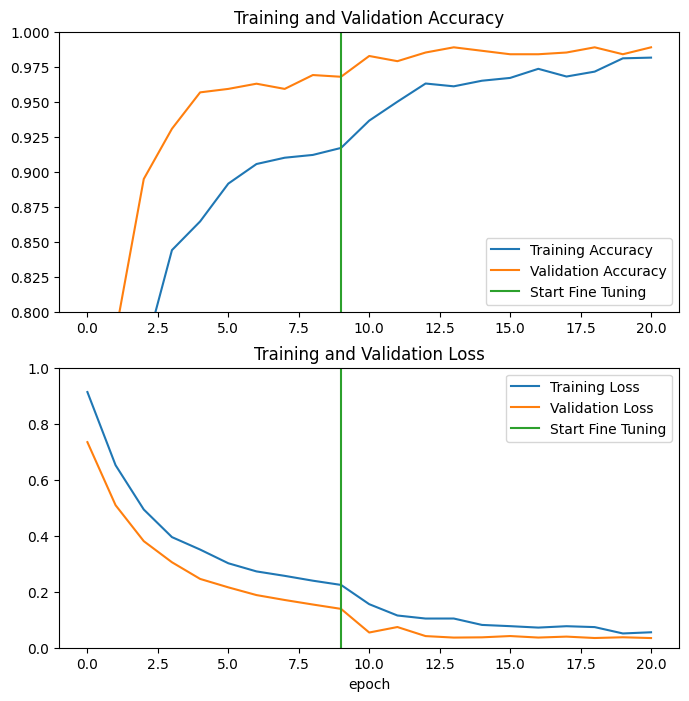

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [37]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/6 [====>.........................] - ETA: 0s - loss: 0.0801 - accuracy: 0.9688

3/6 [==============>...............] - ETA: 0s - loss: 0.0428 - accuracy: 0.9896

5/6 [========================>.....] - ETA: 0s - loss: 0.0277 - accuracy: 0.9937

6/6 [==============================] - 0s 26ms/step - loss: 0.0262 - accuracy: 0.9948


Test accuracy : 0.9947916865348816


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [0 1 0 1 1 1 0 1 1 0 1 0 0 0 0 1 1 0 1 0 1 1 1 1 0 1 0 1 0 1 1 0]
Labels:
 [0 1 0 1 1 1 0 1 1 0 1 0 0 0 0 1 1 0 1 0 1 1 1 1 0 1 0 1 0 1 1 0]


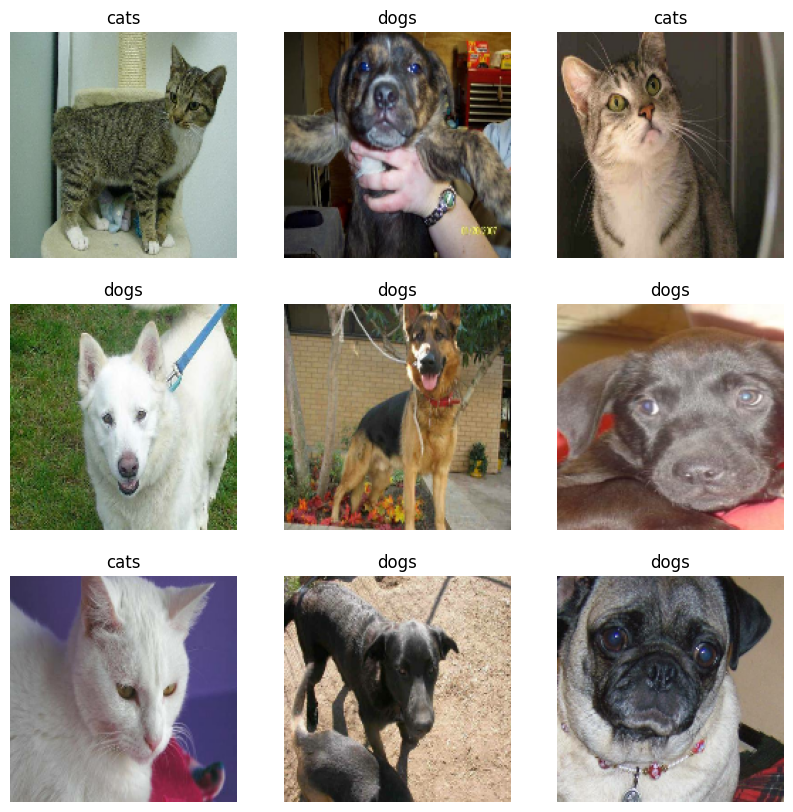

In [38]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
